In [ ]:
import os
import io
import time
import logging
import random
import re
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime, timedelta
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import set_with_dataframe
from sqlalchemy import create_engine
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.errors import HttpError
from gspread_formatting import CellFormat, TextFormat, Color, Borders, Border, set_column_width, format_cell_range
from gspread_formatting import batch_updater
from googleapiclient.http import HttpRequest
import ipywidgets as widgets
from IPython.display import display, clear_output
import base64
from email.message import EmailMessage
from google_auth_oauthlib.flow import InstalledAppFlow
import matplotlib.pyplot as plt
from googleapiclient.http import MediaFileUpload

# ENABLE DYNAMIC SCRIPT DIRECTORY 

In [ ]:
script_dir = os.getcwd()
print(script_dir)

#background_data_dir = script_dir + '\\' + 'Background Data Folder'
"""os.path.join adds the appropriate path separator (\ or /) based on the operating system"""
background_data_dir = os.path.join(script_dir, 'Background Data Folder')
if not os.path.exists(background_data_dir):
    os.makedirs(background_data_dir)

#report_dir = script_dir + '\\' + 'Reports Folder'
report_dir = os.path.join(script_dir, 'Reports Folder') 
if not os.path.exists(report_dir):
    os.makedirs(report_dir)

data_supplied_dir = os.path.join(script_dir, 'Data Supplied Folder')
if not os.path.exists(data_supplied_dir):
    os.makedirs(data_supplied_dir)

c:\Users\nicola\Desktop\VisualCode Workspace\Team Meeting Update

## SPECIFY DIRECTORIES

In [ ]:
master_data_dir = os.path.join(background_data_dir, 'master_data.db')
if not os.path.exists(master_data_dir):
    os.makedirs(master_data_dir)

previous_data_dir = os.path.join(background_data_dir, 'previous_errors_n_reponse_times_data.db')
if not os.path.exists(previous_data_dir):
    os.makedirs(previous_data_dir)


gmail_auth_dir = os.path.join(background_data_dir, 'GmailAuth.json')
if not os.path.exists(gmail_auth_dir):
    os.makedirs(gmail_auth_dir)

gmail_token_dir = os.path.join(background_data_dir, 'GmailToken.json')
if not os.path.exists(gmail_token_dir):
    os.makedirs(gmail_token_dir)

gdrive_auth_dir = os.path.join(background_data_dir, 'GoogleAuth.json')
if not os.path.exists(gdrive_auth_dir):
    os.makedirs(gdrive_auth_dir)


# GET MASTER DATA 
## REPORTING DATE 

In [ ]:
conn = sqlite3.connect(master_data_dir) 
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT ReportingDate FROM MasterData")   
periods = [row[0] for row in cursor.fetchall()]
conn.close()


out = widgets.Output()

dropdown = widgets.Dropdown(
    options=periods,
    description='Reporting Date:',
    disabled=False,
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global selected_reporting_date
        selected_reporting_date = change['new']
        with out:
            clear_output()
            print(f"Selected Period: {selected_reporting_date}")

dropdown.observe(on_change)

In [ ]:
with out:
    display(dropdown)

display(out)

In [ ]:
selected_reporting_date 

'02 May 2025'

In [ ]:
str_ReportingDate = selected_reporting_date
datetime_ReportingDate = datetime.strptime(selected_reporting_date, '%d %b %Y').date()
formatted_ReportingDate = datetime_ReportingDate.strftime('%d %m %Y')

RunDate = datetime_ReportingDate - timedelta(days=1)
formatted_RunDate = f"{RunDate .day:02d} {RunDate .month:02d} {RunDate .year}"
#formatted_RunDate = RunDate.strftime('%d %m %Y')

Designated_Filename = f"KIT 3 Online Reporting Data {formatted_RunDate}.xlsx"

1. Using f-string with manual formatting: 

    formatted_RunDate = f"{RunDate.day:02d} {RunDate.month:02d} {RunDate.year}"

        RunDate.day:02d formats the day with two digits (e.g., 01, 09, 23).

        RunDate.month:02d does the same for the month.

        RunDate.year just inserts the full year (e.g., 2025).

    This approach is explicit and lets you control each component individually.

2. Using .strftime()

    formatted_RunDate = RunDate.strftime('%d %m %Y')

        %d formats the day as a two-digit number.

        %m formats the month as a two-digit number.

        %Y formats the year as a four-digit number.

    This method is cleaner and more concise, especially useful when dealing with more complex date formats.


## TESTING

In [ ]:
datetime_ReportingDate

datetime.date(2025, 5, 2)

In [ ]:
formatted_ReportingDate

'02 05 2025'

In [ ]:
RunDate

datetime.date(2025, 5, 1)

In [ ]:
formatted_RunDate

'01 05 2025'

In [ ]:
Designated_Filename

'KIT 3 Online Reporting Data 01 05 2025.xlsx'

## CORRESPONDING DATA

In [ ]:
conn = sqlite3.connect(master_data_dir) 
cursor = conn.cursor() ## SOLUTION TO ProgramError: cannot operate on a closed database connection
cursor.execute("SELECT * FROM MasterData WHERE ReportingDate = ?", (str_ReportingDate,))
row = cursor.fetchone()

if row:
    column_names = [description[0] for description in cursor.description]
    
    for key, value in zip(column_names, row):
        if key in ["StartDate", "EndDate", "ReportingDate"] and isinstance(value, str):
            # Convert string to datetime.date
            try:
                # For StartDate and EndDate, use ISO format (YYYY-MM-DD)
                if key in ["StartDate", "EndDate"]:
                    value = datetime.strptime(value, "%Y-%m-%d").date()
                else:
                    # ReportingDate is in 'dd MMM YYYY' format
                    value = datetime.strptime(value, "%d %b %Y").date()
            except ValueError:
                value = None  # Handle parsing error gracefully
        
    
        globals()[key] = value
        
        print(f"{key} = {value} ({type(value).__name__})")
else:
    print(f"No row found for ReportingDate = {formatted_ReportingDate}")

conn.close()

-------------------------------------------------------------------------------------------------------
ProgrammingError                                                   Traceback (most recent call last)
Cell In[20], line 3
      1 conn = sqlite3.connect(master_data_dir) 
----> 3 cursor.execute("SELECT * FROM MasterData WHERE ReportingDate = ?", (str_ReportingDate,))
      4 row = cursor.fetchone()
      6 if row:

ProgrammingError: Cannot operate on a closed database.

id = 17 (int)
StartDate = 2025-04-24 (date)
EndDate = 2025-05-01 (date)
WeekNumber = 17 (int)
YearWeek = 202517 (int)
CurrentSheetName = 24 Apr - 30 Apr (str)
CurrentPeriod = 24 Apr 2025 - 01 May 2025 (str)
PeriodName = 202517 - 24 Apr 2025 - 01 May 2025 (str)
PreviousSheetName = 17 Apr - 23 Apr (str)
NextSheetName = 01 May - 07 May (str)
ReportingDate = 2025-05-02 (date)

In [ ]:
YeakWeek = YearWeek
WeekNumber = WeekNumber
CurrentSheetName = CurrentSheetName
CurrentPeriod = CurrentPeriod
PeriodName = PeriodName
PreviousSheetName = PreviousSheetName
NextSheetName = NextSheetName
ReportingDate = ReportingDate

# CHECK CONNECTION TO GMAIL AND GOOGLE DRIVE

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

###

GOOGLE_SERVICE_ACCOUNT_FILE = os.getenv('SERVICE_ACCOUNT_FILE',gdrive_auth_dir)

logging.info(f"Attempting to use service account file: {GOOGLE_SERVICE_ACCOUNT_FILE}")

if not os.path.exists(GOOGLE_SERVICE_ACCOUNT_FILE):
    logging.error(f"Service account file not found: {GOOGLE_SERVICE_ACCOUNT_FILE}")
    raise FileNotFoundError(f"Service account file not found: {GOOGLE_SERVICE_ACCOUNT_FILE}")

logging.info("File found, proceeding with authentication...")

###

GMAIL_SERVICE_ACCOUNT_FILE = os.getenv('SERVICE_ACCOUNT_FILE', gmail_auth_dir)

logging.info(f"Attempting to use service account file: {GMAIL_SERVICE_ACCOUNT_FILE}")

if not os.path.exists(GMAIL_SERVICE_ACCOUNT_FILE):
    logging.error(f"Service account file not found: {GMAIL_SERVICE_ACCOUNT_FILE}")
    raise FileNotFoundError(f"Service account file not found: {GMAIL_SERVICE_ACCOUNT_FILE}")

logging.info("File found, proceeding with authentication...")


2025-05-23 08:03:04,748 - INFO - Attempting to use service account file: c:\Users\nicola\Desktop\VisualCode Workspace\Team Meeting Update\Data Supplied Folder\GoogleAuth.json
2025-05-23 08:03:04,748 - INFO - File found, proceeding with authentication...
2025-05-23 08:03:04,748 - INFO - Attempting to use service account file: c:\Users\nicola\Desktop\VisualCode Workspace\Team Meeting Update\Data Supplied Folder\GmailAuth.json
2025-05-23 08:03:04,748 - INFO - File found, proceeding with authentication...

# DEFINED FUCNTIONS
## google sheets and drive authentication

In [ ]:
def authenticate_gsheets(return_gspread=False):
    """
    Authenticate using google-auth for gspread or Google Sheets API.
    """
    try:
        SCOPES = [
            "https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive",
            "https://www.googleapis.com/auth/spreadsheets"
        ]
        creds = Credentials.from_service_account_file(GOOGLE_SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        if return_gspread:
            gc = gspread.authorize(creds)
            logging.debug("gspread authentication successful")
            return creds, gc
        else:
            sheets_service = build('sheets', 'v4', credentials=creds)
            logging.debug("Sheets API authentication successful")
            return creds, sheets_service
    except Exception as e:
        logging.error(f"Failed to authenticate with Google Sheets: {e}")
        raise

def authenticate_gdrive():
    """
    Authenticate and return Google Drive API service.
    """
    try:
        SCOPES = ['https://www.googleapis.com/auth/drive']
        creds = Credentials.from_service_account_file(GOOGLE_SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        gc = gspread.authorize(creds)
        drive_service = build('drive', 'v3', credentials=creds)
        logging.debug("Drive API authentication successful")
        return creds, gc, drive_service
    except Exception as e:
        logging.error(f"Failed to authenticate with Google Drive: {e}")
        raise

def execute_with_backoff(func,*args,max_retries=5,**kwargs):
    for attempt in range(max_retries):
        try:
            result=func(*args,**kwargs)
            if isinstance(result,HttpRequest):
                result=result.execute()
            return result
        except(HttpError,gspread.exceptions.APIError) as e:
            if 'Quota exceeded' in str(e) or getattr(e,'status',0)==429:
                if attempt==max_retries-1:
                    logging.error(f"Max retries reached for {func.__name__}: {e}")
                    raise
                sleep_time=(2**attempt)+(random.randint(0,1000)/1000)
                logging.warning(f"Quota exceeded, retrying in {sleep_time:.2f} seconds...")
                time.sleep(sleep_time)
            else:
                raise
        except Exception as e:
            logging.error(f"Unexpected error in {func.__name__}: {e}")
            raise

## FETCH DATA FROM DRIVE
### current weeks error count

In [ ]:
def fetch_current_errors():
    try:
        _, gc, _ = authenticate_gdrive()
        spreadsheet = gc.open('ERROR REPORT Current Week')
        current_sheet = spreadsheet.worksheet(CurrentSheetName)
        data = current_sheet.get_all_records()
        return pd.DataFrame(data)
    except Exception as e:
        logging.error(f"Failed to fetch Sheet: {e}")
        raise

### client names

In [ ]:
def fetch_client_names():
    try:
        _, gc, _ = authenticate_gdrive()
        spreadsheet = gc.open('Additional Data')
        sheet = spreadsheet.worksheet('Client Names Sheet')
        data = sheet.get_all_records()
        df = pd.DataFrame(data)
        df = df[~df['Other1'].isnull() & (df['Other1'].str.strip() != '')]  #ignore those for which no alternative name is listed
        ClientNames_dict = clients_df_to_custom_dict(df)
        return ClientNames_dict # return as dictionary 
    
    except Exception as e:
        logging.error(f"Failed to fetch Client Names Sheet: {e}")
        raise   

#### standardize client names

In [ ]:
def clean_string(s):
    return str(s).strip().lower()


def extract_dates(text):
    match = re.search(r'(\d{1,2} \w{3}) \d{4} - (\d{1,2} \w{3}) \d{4}', text)
    if match:
        return f"{match.group(1)} - {match.group(2)}"
    return None  # or return text if no match is found


In [ ]:
def clients_df_to_custom_dict(df):
    result = {}
    for _, row in df.iterrows():
        values = []
        # Append non-null, non-empty values from Other1, Other2, and Other3
        for col in ['Other1', 'Other2', 'Other3']:
            if pd.notnull(row[col]) and row[col] != '':
                values.append(row[col])
        result[row['Client Name']] = values
    return result


In [ ]:
def standardize_client_names(df, df_name):

    ClientNames_dict = fetch_client_names()
    Nonstrd_ClientNames_list = [item for value in ClientNames_dict.values() for item in (value if isinstance(value, (list, tuple)) else [value])]

    Nonstrd_ClientNames_list = [clean_string(i) for i in Nonstrd_ClientNames_list]
    def check_match(text):
        if pd.isna(text):  # Handle NaN/None values
            return False
        cleaned_text = clean_string(text)
        return cleaned_text in Nonstrd_ClientNames_list
    
    orginal_colname = df.columns[0]
    orginal_cols = list(df.columns)

    # Standardize column
    df = df.rename(columns={df.columns[0]: 'temp col'})
    # Add a new column 'Match' to the DataFrame
    df['Match'] = df['temp col'].apply(check_match)

    value_map = {}
    for key, values in ClientNames_dict.items():
        for value in values:
            value_map[clean_string(value)] = key
    
    # Function to apply to each row
    def get_standard_value(row):
        if row['Match']:  # If Match is True
            cleaned_col = clean_string(row['temp col'])
            return value_map.get(cleaned_col, row['temp col'])  # Return key if found, else original
        return row['temp col']  # Return original if Match is False
    
    # Add 'standard' column to DataFrame
    df['standard'] = df.apply(get_standard_value, axis=1)
    df = df.drop(columns=['temp col'])
    df = df.rename(columns={'standard': orginal_colname})
    df = df.reindex(columns=orginal_cols) # reorder
    print('Client Names standardized for {}'.format(df_name))
    
    return df

### fetch leave and kindle employees assigned to client

In [ ]:
def fetch_leave(reporting_date=ReportingDate):
    reporting_date = pd.Timestamp(reporting_date)
    try:
        _, gc, _ = authenticate_gdrive()
        spreadsheet = gc.open('Additional Data')
        sheet = spreadsheet.worksheet('Leave Sheet')
        data = pd.DataFrame(sheet.get_all_records())

        data['Leave - Start Date'] = pd.to_datetime(data['Leave - Start Date'], format="%d/%m/%Y", errors='coerce')
        data['Leave - End Date'] = pd.to_datetime(data['Leave - End Date'], format="%d/%m/%Y", errors='coerce')
        data['On Leave'] = False

        for index, row in data.iterrows():
            start = row['Leave - Start Date']
            end = row['Leave - End Date']

            if pd.notnull(start) and start < reporting_date <= end:
                data.at[index, 'On Leave'] = True
            elif pd.isnull(start) and pd.notnull(end) and end > reporting_date:
                data.at[index, 'On Leave'] = True

        return data
    except Exception as e:
        logging.error(f"Failed to fetch Leave Sheet: {e}")
        raise

In [ ]:
def fetch_kindle_employees():
    try:
        _, gc, _ = authenticate_gdrive()
        spreadsheet = gc.open('Additional Data')
        sheet = spreadsheet.worksheet('Person Responsible Sheet')
        data = sheet.get_all_records()
        data = pd.DataFrame(data)
        return data
    except Exception as e:
        logging.error(f"Failed to fetch Person Responsible Sheet: {e}")
        raise

#### determine individuals repsonsible for reporting 

In [ ]:
def determine_person_responsible(reporting_date=ReportingDate):
    reporting_date = pd.Timestamp(reporting_date)
    Employee_data = fetch_kindle_employees()
    LeaveStatus_data = fetch_leave(reporting_date)

    def determine_devs_turn(row):
        rotation_freq = row['Rotation Frequency (Weeks)']
        if pd.isna(rotation_freq) or rotation_freq == '':
        # Return Developer 1's name if valid, otherwise return empty string
            dev1 = row['Developer 1']
            if dev1 and dev1 != '?' and not pd.isna(dev1):
                return dev1.strip()
            return ''
    
        # Convert rotation_freq to an integer
        try:
            rotation_freq = int(rotation_freq)
        except (ValueError, TypeError):
            return ''
    
        if rotation_freq <= 0:
            return ''

        # Determine which developer columns to consider (Developer 1 to Developer n)
        developer_columns = ['Developer 1', 'Developer 2', 'Developer 3', 'Developer 4'][:rotation_freq]
    
        # Get the list of developers from the relevant columns
        developers = []
        for col in developer_columns:
            dev = row[col]
            if dev and dev != '?' and not pd.isna(dev):
            # Handle multiple developers in the same column (e.g., "Joel;Brendan")
                developers.extend([d.strip() for d in dev.split(';') if d.strip()])
    
        if not developers:
            return ''
    
        if not isinstance(WeekNumber, int):
            raise ValueError(f"current_week_number must be an integer, got {type(WeekNumber)}: {WeekNumber}")
    
        developer_index = (WeekNumber % rotation_freq) % len(developers)
    
        if not isinstance(developer_index, int):
            raise ValueError(f"developer_index is not an integer, got {type(developer_index)}: {developer_index}")
    
        return developers[developer_index]

    Employee_data['Developer'] = Employee_data.apply(determine_devs_turn, axis=1)

    on_leave_list = LeaveStatus_data.loc[LeaveStatus_data['On Leave'] == True, 'Kindle Employee'].dropna().tolist()

    def assign_functionalerror_reporter(row):
        dev = row['Developer']
        dev2 = row['Developer 2']
        dev3 = row['Developer 3']
        dev4 = row['Developer 4']
        emergency = row['In Case of Emergency']
    
        dev_on_leave = pd.notna(dev) and dev in on_leave_list
        dev2_on_leave = pd.notna(dev2) and dev2 in on_leave_list
        dev3_on_leave = pd.notna(dev3) and dev3 in on_leave_list
        dev4_on_leave = pd.notna(dev4) and dev4 in on_leave_list
    
        if pd.notna(dev) and not dev_on_leave:
            return dev
        elif pd.notna(dev2) and not dev2_on_leave:
            return dev2
        elif pd.notna(dev3) and not dev3_on_leave:
            return dev3
        elif pd.notna(dev4) and not dev4_on_leave:
            return dev4
        elif pd.notna(emergency):
            return emergency
        else:
            return None  # or raise an error if no responsible person can be assigned
        
    Employee_data['Functional Errors Reporter'] = Employee_data.apply(assign_functionalerror_reporter, axis=1)


    def assign_clientmovement_reporter(row):
        if row['Designated Reporter on Client Movement'] == 'Developer':
            return assign_functionalerror_reporter(row)

        if row['Designated Reporter on Client Movement'] == 'Business Analyst':
            ba1 = row['Business Analyst 1']
            ba2 = row['Business Analyst 2']
            emergency = row['In Case of Emergency']

            ba1_on_leave = pd.notna(ba1) and ba1 in on_leave_list
            ba2_on_leave = pd.notna(ba2) and ba2 in on_leave_list

            if pd.notna(ba1) and not ba1_on_leave:
                return ba1
            elif pd.notna(ba2) and not ba2_on_leave:
                return ba2
            elif pd.notna(emergency):
                return emergency
            else:
                return None  # or raise an error if no responsible person can be assigned

        return None  # If "Designated Reporter on Client Movement" is neither BA nor Developer

    
    Employee_data['Client Movement Reporter'] = Employee_data.apply(assign_clientmovement_reporter, axis=1)

    PersonsResponsible_data = Employee_data.drop(['Designated Reporter on Client Movement', 'Business Analyst 1', 'Business Analyst 2', 'Key Resource',
       'Developer 1', 'Developer 2', 'Developer 3', 'Developer 4',
       'Rotation Frequency (Weeks)', 'In Case of Emergency', 'Developer'], axis=1)
    
    PersonsResponsible_data = standardize_client_names(PersonsResponsible_data, 'PersonsResponsible_data')
    
    return PersonsResponsible_data

#### apply to client movement and non-/functional error count
##### fetch client movement

In [ ]:
def fetch_client_movement():
    """
    remove all rows after the row where 'Tenant Name' has 'Total'
    """
    try:
        _, gc, _ = authenticate_gdrive()
        spreadsheet = gc.open('Weekly Movement')
        sheet = spreadsheet.worksheet('Export')
        
        data = sheet.get_all_records()
        
        ClientMovement_data = pd.DataFrame(data[1:], columns=data[0])

        if 'Tenant Name' in ClientMovement_data.columns:
            total_index = ClientMovement_data[ClientMovement_data['Tenant Name'].str.contains('Total', na=False)].index
            if not total_index.empty:
                ClientMovement_data = ClientMovement_data.loc[:total_index[0]-1]

        ClientMovement_data = standardize_client_names(ClientMovement_data, 'ClientMovement_data')

        return ClientMovement_data

    except Exception as e:
        logging.error(f"Failed to fetch Client Movement: {e}")
        raise


##### determine error count 

In [ ]:
def determine_error_count():
    pd.set_option('future.no_silent_downcasting', True)
    
    Current_Error_data = fetch_current_errors()
    Current_Error_data['Client'] = Current_Error_data['Client'].str.title()
    Current_Error_data['Client'] = Current_Error_data['Client'].replace('', np.nan)
    Current_Error_data['Period'] = Current_Error_data['Period'].replace('', np.nan)
    Current_Error_data['Client'] = Current_Error_data['Client'].ffill().bfill()
    Current_Error_data['Period'] = Current_Error_data['Period'].ffill().bfill()
    Current_Error_data = Current_Error_data.infer_objects(copy=False)
    Current_Error_data['Functional Error Y/N'] = Current_Error_data['Functional Error Y/N'].astype(str).str.strip().str.upper()

    Current_Error_grouped = Current_Error_data.groupby(['Client', 'Period', 'Functional Error Y/N'], as_index=False)['No of times error occurred'].sum()
    Current_Error_grouped.rename(columns={'No of times error occurred': 'Total Errors'}, inplace=True)

    Current_Error_grouped.rename(columns={'Functional Error Y/N': 'FunctionalError_Y/N'}, inplace=True)

    Current_ErrorCount_data = Current_Error_grouped.pivot_table(
        index=['Client', 'Period'],
        columns='FunctionalError_Y/N',
        values='Total Errors',
        aggfunc='sum',
        fill_value=0
        ).reset_index()
    Current_ErrorCount_data = Current_ErrorCount_data.infer_objects(copy=False)
    
    Current_ErrorCount_data.columns.name = None  # Remove the "FunctionalError_Y/N" header
    Current_ErrorCount_data = Current_ErrorCount_data.drop(columns=[''])

    Current_ErrorCount_data.rename(columns={'Y': 'FunctionalErrors', 'N': 'NonFunctionalErrors'}, inplace=True)

    Current_ErrorCount_data = standardize_client_names(Current_ErrorCount_data, 'Current_ErrorCount_data')

    return Current_ErrorCount_data

In [ ]:
PersonsResponsible_data = determine_person_responsible()
BAResponsible_data = PersonsResponsible_data[['Clients','Client Movement Reporter']].rename(columns={'Clients':'Tenant Name'})
DEVResponsible_data = PersonsResponsible_data[['Clients','Functional Errors Reporter']].rename(columns={'Clients':'Company'})

----------------------------------------------------------------------------------------------------------------------------
PermissionError                                                    Traceback (most recent call last)
Cell In[21], line 1
----> 1 PersonsResponsible_data = determine_person_responsible()
      2 BAResponsible_data = PersonsResponsible_data[['Clients','Client Movement Reporter']].rename(columns={'Clients':'Tenant Name'})
      3 DEVResponsible_data = PersonsResponsible_data[['Clients','Functional Errors Reporter']].rename(columns={'Clients':'Company'})

Cell In[18], line 3, in determine_person_responsible(reporting_date)
      1 def determine_person_responsible(reporting_date=ReportingDate):
      2     reporting_date = pd.Timestamp(reporting_date)
----> 3     Employee_data = fetch_kindle_employees()
      4     LeaveStatus_data = fetch_leave(reporting_date)
      6     def determine_devs_turn(row):

Cell In[17], line 3, in fetch_kindle_employees()
      1 def fetch_kindle_employees():
      2     try:
----> 3         _, gc, _ = authenticate_gdrive()
      4         spreadsheet = gc.open('Additional Data')
      5         sheet = spreadsheet.worksheet('Person Responsible Sheet')

Cell In[10], line 30, in authenticate_gdrive()
     28 try:
     29     SCOPES = ['https://www.googleapis.com/auth/drive']
---> 30     creds = Credentials.from_service_account_file(GOOGLE_SERVICE_ACCOUNT_FILE, scopes=SCOPES)
     31     gc = gspread.authorize(creds)
     32     drive_service = build('drive', 'v3', credentials=creds)

File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\google\oauth2\service_account.py:260, in Credentials.from_service_account_file(cls, filename, **kwargs)
    248 @classmethod
    249 def from_service_account_file(cls, filename, **kwargs):
    250     """Creates a Credentials instance from a service account json file.
    251 
    252     Args:
   (...)    258             credentials.
    259     """
--> 260     info, signer = _service_account_info.from_filename(
    261         filename, require=["client_email", "token_uri"]
    262     )
    263     return cls._from_signer_and_info(signer, info, **kwargs)

File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\google\auth\_service_account_info.py:78, in from_filename(filename, require, use_rsa_signer)
     64 def from_filename(filename, require=None, use_rsa_signer=True):
     65     """Reads a Google service account JSON file and returns its parsed info.
     66 
     67     Args:
   (...)     76             info and a signer instance.
     77     """
---> 78     with io.open(filename, "r", encoding="utf-8") as json_file:
     79         data = json.load(json_file)
     80         return data, from_dict(data, require=require, use_rsa_signer=use_rsa_signer)

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\nicola\\Desktop\\VisualCode Workspace\\Team Meeting Update\\Data Supplied Folder\\GoogleAuth.json'

###### TROUBLESHOOTING


In [ ]:
GOOGLE_SERVICE_ACCOUNT_FILE = r"c:\Users\nicola\Desktop\VisualCode Workspace\Team Meeting Update\Data Supplied Folder\GoogleAuth.json"
SCOPES = ['https://www.googleapis.com/auth/drive']

logging.basicConfig(level=logging.DEBUG)
try:
    print(f"File exists: {os.path.exists(GOOGLE_SERVICE_ACCOUNT_FILE)}")
    print(f"File readable: {os.access(GOOGLE_SERVICE_ACCOUNT_FILE, os.R_OK)}")
    creds = Credentials.from_service_account_file(GOOGLE_SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    logging.debug("Authentication successful")
except Exception as e:
    logging.error(f"Authentication failed: {e}")
    raise

2025-05-23 08:48:01,014 - ERROR - Authentication failed: [Errno 13] Permission denied: 'c:\\Users\\nicola\\Desktop\\VisualCode Workspace\\Team Meeting Update\\Data Supplied Folder\\GoogleAuth.json'
File exists: True
File readable: True

NOT USING <strong>from google.oauth2.credentials import Credentials</strong>

    google.oauth2.service_account.Credentials 

is designed for service account authentication, which uses a JSON key file (like GoogleAuth.json) to authenticate programmatically without user interaction. This is what you need for server-to-server interactions with Google APIs, such as accessing Google Drive or Sheets.


    google.oauth2.credentials.Credentials 

is for OAuth 2.0 user authentication, typically used for scenarios where a user authorizes access via a browser-based flow. It requires a client ID, client secret, and access/refresh tokens, not a service account JSON file. It does not have a from_service_account_file method, so using it would break your code and is not suitable for your automated script.

Reproduce the Error with Debug Information

###### Test File Accessibility Explicitly

In [ ]:
logging.basicConfig(level=logging.DEBUG)
GOOGLE_SERVICE_ACCOUNT_FILE = r"c:\Users\nicola\Desktop\VisualCode Workspace\Team Meeting Update\Data Supplied Folder\GoogleAuth.json"

try:
    logging.debug(f"Attempting to read file: {GOOGLE_SERVICE_ACCOUNT_FILE}")
    with open(GOOGLE_SERVICE_ACCOUNT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
        logging.debug(f"File contents: {data}")
except Exception as e:
    logging.error(f"Failed to read file: {e}", exc_info=True)
    raise

2025-05-23 08:53:52,418 - ERROR - Failed to read file: [Errno 13] Permission denied: 'c:\\Users\\nicola\\Desktop\\VisualCode Workspace\\Team Meeting Update\\Data Supplied Folder\\GoogleAuth.json'
Traceback (most recent call last):
  File "C:\Users\nicola\AppData\Local\Temp\ipykernel_9920\3547980247.py", line 6, in <module>
    with open(GOOGLE_SERVICE_ACCOUNT_FILE, 'r', encoding='utf-8') as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 325, in _modified_open
    return io_open(file, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: 'c:\\Users\\nicola\\Desktop\\VisualCode Workspace\\Team Meeting Update\\Data Supplied Folder\\GoogleAuth.json'

###### Re-Test with Explict Open

In [ ]:
logging.basicConfig(level=logging.DEBUG)
GOOGLE_SERVICE_ACCOUNT_FILE = r"c:\Users\nicola\Desktop\VisualCode Workspace\Team Meeting Update\Data Supplied Folder\GoogleAuth.json"

try:
    logging.debug(f"File path: {GOOGLE_SERVICE_ACCOUNT_FILE}")
    logging.debug(f"File exists: {os.path.exists(GOOGLE_SERVICE_ACCOUNT_FILE)}")
    logging.debug(f"File readable: {os.access(GOOGLE_SERVICE_ACCOUNT_FILE, os.R_OK)}")
    logging.debug("Attempting to read file")
    with open(GOOGLE_SERVICE_ACCOUNT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
        logging.debug(f"File contents loaded successfully")
except PermissionError as e:
    logging.error(f"Permission error: {e}", exc_info=True)
    raise
except Exception as e:
    logging.error(f"Failed to read file: {e}", exc_info=True)
    raise

2025-05-23 08:55:55,263 - ERROR - Permission error: [Errno 13] Permission denied: 'c:\\Users\\nicola\\Desktop\\VisualCode Workspace\\Team Meeting Update\\Data Supplied Folder\\GoogleAuth.json'
Traceback (most recent call last):
  File "C:\Users\nicola\AppData\Local\Temp\ipykernel_9920\2185016895.py", line 9, in <module>
    with open(GOOGLE_SERVICE_ACCOUNT_FILE, 'r', encoding='utf-8') as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 325, in _modified_open
    return io_open(file, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: 'c:\\Users\\nicola\\Desktop\\VisualCode Workspace\\Team Meeting Update\\Data Supplied Folder\\GoogleAuth.json'

NOTICE wrong directory specified when attempting to locate file such that folders created with specified names 
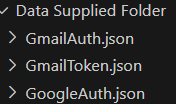

gmail_auth_dir = os.path.join(data_supplied_dir, 'GmailAuth.json')

gmail_token_dir = os.path.join(data_supplied_dir, 'GmailToken.json')

gdrive_auth_dir = os.path.join(data_supplied_dir, 'GoogleAuth.json')

##### 

2025-05-23 09:15:30,366 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:15:36,903 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:15:40,055 - INFO - file_cache is only supported with oauth2client<4.0.0
Client Names standardized for PersonsResponsible_data

##### client movement

In [ ]:
ClientMovement_data = fetch_client_movement()
Onlines_data = pd.merge(ClientMovement_data, BAResponsible_data, on='Tenant Name', how='left')
Onlines_data.loc[Onlines_data['Difference'] <= 0, 'Client Movement Reporter'] = np.nan

try:
    _, gc, _ = authenticate_gdrive()
    spreadsheet = gc.open('Persons Responsible')

    worksheet_title = 'Onlines'
    try:
        sheet = spreadsheet.worksheet(worksheet_title)
    except gspread.exceptions.WorksheetNotFound:
        sheet = spreadsheet.add_worksheet(title=worksheet_title, rows=100, cols=26)
        logging.info(f"Created new worksheet: {worksheet_title}")

    data = [Onlines_data.columns.tolist()] + Onlines_data.astype(object).where(pd.notnull(Onlines_data), None).values.tolist()

    # Clear sheet data    
    execute_with_backoff(sheet.clear)
    execute_with_backoff(sheet.update, data, 'A1', value_input_option='RAW')

    # Format the data as a table
    set_column_width(sheet, 'A', 250)  
    set_column_width(sheet, 'F', 100) 
    set_column_width(sheet, 'G', 150) 

    num_rows = len(data)
    num_cols = len(data[0])
    range_notation = f'A1:{chr(65 + num_cols - 1)}{num_rows}'

    # Set header row height using batch update
    spreadsheet.batch_update({
            "requests": [
                {
                    "updateDimensionProperties": {
                        "range": {
                            "sheetId": sheet.id,
                            "dimension": "ROWS",
                            "startIndex": 0,  # Row 1 (0-based index)
                            "endIndex": 1     # Only the first row
                        },
                        "properties": {
                            "pixelSize": 30  # Set height to 30 pixels
                        },
                        "fields": "pixelSize"
                    }
                }
            ]
        })

    # Bold headers and format
    format_cell_range(
            sheet,
            f'A1:{chr(65 + num_cols - 1)}1',
            CellFormat(
                textFormat=TextFormat(bold=True),
                horizontalAlignment='CENTER',
                verticalAlignment='MIDDLE',
                backgroundColor=Color(0.9, 0.9, 0.9)  # Light gray background for headers
            )
        )

    # Add borders to create a table effect
    format_cell_range(
            sheet,
            range_notation,
            CellFormat(
                borders=Borders(
                    top=Border('SOLID'),
                    bottom=Border('SOLID'),
                    left=Border('SOLID'),
                    right=Border('SOLID')
                )
            )
        )

    # Add filter buttons to the table
    spreadsheet.batch_update({
            "requests": [
                {
                    "setBasicFilter": {
                        "filter": {
                            "range": {
                                "sheetId": sheet.id,
                                "startRowIndex": 0,  # Start at row 1
                                "endRowIndex": num_rows,  # End at last row
                                "startColumnIndex": 0,  # Start at column A
                                "endColumnIndex": num_cols  # End at last column
                            }
                        }
                    }
                }
            ]
        })

    logging.info(f"Data successfully added to {worksheet_title} worksheet of Persons Responsible workbook")
except Exception as e:
    logging.error(f"Failed to write DataFrame to sheet, apply formatting, or add filter: {e}")
    raise

2025-05-23 09:16:54,748 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:16:59,315 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:17:02,593 - INFO - file_cache is only supported with oauth2client<4.0.0
Client Names standardized for ClientMovement_data
2025-05-23 09:17:13,560 - INFO - Data successfully added to Onlines worksheet of Persons Responsible workbook

##### functional errors 

In [ ]:
Current_ErrorCount_data = determine_error_count()
Current_ErrorCount_data = Current_ErrorCount_data.rename(columns={'Client': 'Company'}) 
Current_ErrorCount_data = Current_ErrorCount_data.drop(['Period'], axis=1)
FunctionalErrors_data = pd.merge(Current_ErrorCount_data, DEVResponsible_data, on='Company', how='left')
FunctionalErrors_data.loc[FunctionalErrors_data['FunctionalErrors'] > 0, 'Functional Errors Reporter'] = np.nan

try:
    _, gc, _ = authenticate_gdrive()
    spreadsheet = gc.open('Persons Responsible')

    # Check if worksheet exists, create if it doesn't
    worksheet_title = 'Functional Errors'
    try:
        sheet = spreadsheet.worksheet(worksheet_title)
    except gspread.exceptions.WorksheetNotFound:
        sheet = spreadsheet.add_worksheet(title=worksheet_title, rows=100, cols=26)
        logging.info(f"Created new worksheet: {worksheet_title}")

    data = [FunctionalErrors_data.columns.tolist()] + FunctionalErrors_data.astype(object).where(pd.notnull(FunctionalErrors_data), None).values.tolist()
        
    # Clear the sheet and write the data
    execute_with_backoff(sheet.clear)
    execute_with_backoff(sheet.update, data, 'A1', value_input_option='RAW')

    # Format the data as a table
    set_column_width(sheet, 'A', 300)
    set_column_width(sheet, 'B', 50)  
    set_column_width(sheet, 'C', 50) 
    set_column_width(sheet, 'D', 150)
    num_rows = len(data)
    num_cols = len(data[0])
    range_notation = f'A1:{chr(65 + num_cols - 1)}{num_rows}'

    # Set header row height using batch update
    spreadsheet.batch_update({
            "requests": [
                {
                    "updateDimensionProperties": {
                        "range": {
                            "sheetId": sheet.id,
                            "dimension": "ROWS",
                            "startIndex": 0,  # Row 1 (0-based index)
                            "endIndex": 1     # Only the first row
                        },
                        "properties": {
                            "pixelSize": 30  # Set height to 30 pixels
                        },
                        "fields": "pixelSize"
                    }
                }
            ]
        })

    # Bold headers and format
    format_cell_range(
            sheet,
            f'A1:{chr(65 + num_cols - 1)}1',
            CellFormat(
                textFormat=TextFormat(bold=True),
                horizontalAlignment='CENTER',
                verticalAlignment='MIDDLE',
                backgroundColor=Color(0.9, 0.9, 0.9)  # Light gray background for headers
            )
        )

    # Add borders to create a table effect
    format_cell_range(
            sheet,
            range_notation,
            CellFormat(
                borders=Borders(
                    top=Border('SOLID'),
                    bottom=Border('SOLID'),
                    left=Border('SOLID'),
                    right=Border('SOLID')
                )
            )
        )


    # Add filter buttons to the table
    spreadsheet.batch_update({
            "requests": [
                {
                    "setBasicFilter": {
                        "filter": {
                            "range": {
                                "sheetId": sheet.id,
                                "startRowIndex": 0,  # Start at row 1
                                "endRowIndex": num_rows,  # End at last row
                                "startColumnIndex": 0,  # Start at column A
                                "endColumnIndex": num_cols  # End at last column
                            }
                        }
                    }
                }
            ]
        })

    logging.info(f"Data sucessfully added to {worksheet_title} worksheet of Persons Responsible workbook")
except Exception as e:
    logging.error(f"Failed to write DataFrame to sheet, apply formatting, or add filter: {e}")
    raise

2025-05-23 09:20:36,833 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:20:41,363 - INFO - file_cache is only supported with oauth2client<4.0.0
Client Names standardized for Current_ErrorCount_data
2025-05-23 09:20:52,934 - INFO - Data sucessfully added to Functional Errors worksheet of Persons Responsible workbook

In [ ]:
def generate_chart(df, show=False):

    os.makedirs('Reports Folder', exist_ok=True)
    chart_name = f'Bar Graph for {PeriodName}.png'
    
    try:
        x = np.arange(len(df.iloc[:,0]))   ## SOLUTION df['Client'] altered to df.iloc[:,0]
        width = 0.35
        fig, ax = plt.subplots(figsize=(20, 15))  
        ax.bar(x - width/2, df['NonFunctionalErrors'], width, label='Non-Functional Errors')
        ax.bar(x + width/2, df['FunctionalErrors'], width, label='Functional Errors')

        ax.set_xlabel('Client')
        ax.set_ylabel('Error Count')
        ax.set_title(f'Functional vs Non-Functional Errors for {PeriodName}')
        ax.set_xticks(x)
        ax.set_xticklabels(df.iloc[:,0], rotation=45, ha='right')  ## SOLTION df['Client'] altered to df.iloc[:,0]
        ax.legend()
        plt.tight_layout()

        chart_path = os.path.join('Reports Folder', chart_name)
        plt.savefig(chart_path, dpi=900, bbox_inches='tight')  
        plt.close(fig)
        logging.debug(f"Chart saved to {chart_path} with high resolution (DPI=900)")

        if not os.path.exists(chart_path):
            raise FileNotFoundError(f"Chart file {chart_name} was not saved correctly")
    except Exception as e:
        logging.error(f"Failed to generate or save chart: {e}")
        raise
    
    if show: 
        return plt.show()
    
    else:
        return

In [ ]:
generate_chart(Current_ErrorCount_data, show=False)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\pandas\core\indexes\base.py:3805, in Index.get_loc(self, key)
   3804 try:
-> 3805     return self._engine.get_loc(casted_key)
   3806 except KeyError as err:

File index.pyx:167, in pandas._libs.index.IndexEngine.get_loc()

File index.pyx:196, in pandas._libs.index.IndexEngine.get_loc()

File pandas\\_libs\\hashtable_class_helper.pxi:7081, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas\\_libs\\hashtable_class_helper.pxi:7089, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'Client'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
Cell In[26], line 1
----> 1 generate_chart(Current_ErrorCount_data, show=False)

Cell In[25], line 7, in generate_chart(df, show)
      4 chart_name = f'Bar Graph for {PeriodName}.png'
      6 try:
----> 7     x = np.arange(len(df['Client']))
      8     width = 0.35
      9     fig, ax = plt.subplots(figsize=(20, 15))  

File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\pandas\core\frame.py:4102, in DataFrame.__getitem__(self, key)
   4100 if self.columns.nlevels > 1:
   4101     return self._getitem_multilevel(key)
-> 4102 indexer = self.columns.get_loc(key)
   4103 if is_integer(indexer):
   4104     indexer = [indexer]

File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\pandas\core\indexes\base.py:3812, in Index.get_loc(self, key)
   3807     if isinstance(casted_key, slice) or (
   3808         isinstance(casted_key, abc.Iterable)
   3809         and any(isinstance(x, slice) for x in casted_key)
   3810     ):
   3811         raise InvalidIndexError(key)
-> 3812     raise KeyError(key) from err
   3813 except TypeError:
   3814     # If we have a listlike key, _check_indexing_error will raise
   3815     #  InvalidIndexError. Otherwise we fall through and re-raise
   3816     #  the TypeError.
   3817     self._check_indexing_error(key)

KeyError: 'Client'

###### TROUBLESHOOTING

In [ ]:
Current_ErrorCount_data.head()

In [ ]:
# COMPARING OUTPUT 
Current_ErrorCount_data.iloc[:,0]

In [ ]:
Current_ErrorCount_data['Company']

## FETCH DATA FROM LOCAL DEVICE 
### previous error and response times data

In [ ]:
def fetch_previous(YearWeek=YearWeek): 
    engine = create_engine(f'sqlite:///{previous_data_dir}')
    query = f"""
        SELECT * FROM PreviousErrorData
        WHERE CAST(SUBSTR(Period, 1, 6) AS INTEGER) < {YearWeek}
            """
    Previous_Errors_n_ResponseTimes_data = pd.read_sql(query, engine)
    Previous_Errors_n_ResponseTimes_data = standardize_client_names(Previous_Errors_n_ResponseTimes_data,'Previous_Errors_n_ResponseTimes_data')
    
    return Previous_Errors_n_ResponseTimes_data

### current response times

In [ ]:
def fetch_response_times(data_folder = data_supplied_dir): 

    files = os.listdir(data_folder)
    matched_file = None
    for file in files:
        if clean_string(file) == clean_string(Designated_Filename):
            matched_file = file
            break

    if not matched_file:
        available_files = ", ".join(files)
        raise FileNotFoundError(f"File '{Designated_Filename}' not found. Available files: {available_files}")

    file_path = os.path.join(data_folder, matched_file)

    try:
        xl = pd.ExcelFile(file_path)
    except Exception as e:
        raise Exception(f"File found but couldn't be accessed: {str(e)}")

    sheet_name = "This week response times"
    if sheet_name not in xl.sheet_names:
        sheet_name = xl.sheet_names[1]  # Default to last sheet

    try:
        data = xl.parse(sheet_name, header=0)
    except Exception as e:
        raise Exception(f"No valid data found in the '{sheet_name}' sheet: {str(e)}")

    Current_ResponseTimes_data  = standardize_client_names(data, 'Current_ResponseTimes_data')
    Current_ResponseTimes_data = Current_ResponseTimes_data.drop(['FunctionalError', 'NonFunctionalError'], axis=1)
    
    #Current_ResponseTimes_data.to_excel("ResponseTimesQuery.xlsx", index=False)

    return Current_ResponseTimes_data

## CONCATENATE PREVIOUS WITH CURRENT

In [ ]:
def concat_errors_n_responsetimes():
    """
    remove total row of response times
    """
    Current_ResponseTimes_data = fetch_response_times()
    Current_ResponseTimes_data = Current_ResponseTimes_data[~Current_ResponseTimes_data['Period'].isna()] 
    
    Current_ErrorCount_data = determine_error_count()

    Current_ErrorCount_data = Current_ErrorCount_data.rename(columns={'Client': 'Company'}) 
    Current_ErrorCount_data = Current_ErrorCount_data.drop(['Period'], axis=1)

    Current_Errors_n_ResponseTimes_data = pd.merge(Current_ResponseTimes_data, Current_ErrorCount_data, on=['Company'], how='left')
    
    columns_to_convert = ['FunctionalErrors', 'NonFunctionalErrors']
    for col in columns_to_convert:
        Current_Errors_n_ResponseTimes_data[col] = pd.to_numeric(Current_Errors_n_ResponseTimes_data[col], errors='coerce').astype('Int64')
    

    if Current_Errors_n_ResponseTimes_data.duplicated(subset=['Period', 'Company']).any():
        print("Warning: Removing internal duplicates based on Period and Company.")
        Current_Errors_n_ResponseTimes_data = Current_Errors_n_ResponseTimes_data.drop_duplicates(subset=['Period', 'Company'])

    engine = create_engine(f'sqlite:///{previous_data_dir}')

    try:
        with engine.connect() as conn:
            # Get the last entry's Period from PreviousErrorData (most recent by Period)
            last_entry = pd.read_sql("SELECT Period FROM PreviousErrorData ORDER BY Period DESC LIMIT 1", conn)
        
            if last_entry.empty:
                print("Warning: PreviousErrorData table is empty. Cannot verify Period.")
            else:
                last_period = last_entry['Period'].iloc[0]
                last_period_prefix = int(last_period[:6])

                # Get the Period prefix from ErrorReport_data (assuming all rows have the same prefix)
                new_period_prefix = int(Current_ErrorCount_data['Period'].iloc[0][:6])  # First 6 characters

                # Verify that the new year is exactly one more than the last year
                if new_period_prefix == last_period_prefix + 1:
                    print(f"Verification successful: New Period ({new_period_prefix}) is one week after last Period ({last_period_prefix}).")
                else:
                    print(f"Verification failed: New Period ({new_period_prefix}) is not one more than last Period ({last_period_prefix}).")
    except Exception as e:
        print(f"Error during verification: {e}")

    
    try:
        with engine.connect() as conn:
            existing_records = pd.read_sql("SELECT Period, Company FROM PreviousErrorData", conn)

            # Ensure consistent data types for comparison
            for df in [Current_Errors_n_ResponseTimes_data, existing_records]:
                df['Period'] = df['Period'].astype(str)
                df['Company'] = df['Company'].astype(str)

            new_records = Current_Errors_n_ResponseTimes_data.merge(
                existing_records,
                on=['Period', 'Company'],
                how='left',
                indicator=True
            ).query('_merge == "left_only"').drop(columns='_merge')

            if new_records.empty:
                print("No new records to append; all records already exist in PreviousErrorData.")
            else:
                new_records.to_sql('PreviousErrorData', con=engine, if_exists='append', index=False)
                print(f"Successfully appended {len(new_records)} new records to PreviousErrorData table.")
                print("Appended records:")
                print(new_records[['Period', 'Company']])
    except Exception as e:
        print(f"Error checking/appending data: {e}")

    Previous_Errors_n_ResponseTimes_data = fetch_previous()

    Updated_Errors_n_ResponseTimes_data = pd.concat([Previous_Errors_n_ResponseTimes_data, Current_Errors_n_ResponseTimes_data], ignore_index=True)

    return Updated_Errors_n_ResponseTimes_data

# WRITE DATA TO REPORT SHEETS
## complete table of errors and response times

In [ ]:
Updated_Errors_n_ResponseTimes_data = concat_errors_n_responsetimes()
Updated_Errors_n_ResponseTimes_data = Updated_Errors_n_ResponseTimes_data.where(pd.notnull(Updated_Errors_n_ResponseTimes_data), None)

ClientNames_dict = fetch_client_names()

Nonstrd_ClientNames_list = [item for value in ClientNames_dict.values() for item in (value if isinstance(value, (list, tuple)) else [value])]
if not Updated_Errors_n_ResponseTimes_data['Company'].isin(Nonstrd_ClientNames_list).any():
    print("No non-standard company names found.")
else:
    print("There is at least one non-standard company name present.")

Client Names standardized for Current_ErrorCount_data
Error during verification: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Error checking/appending data: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)
2025-05-23 09:30:47,477 - INFO - file_cache is only supported with oauth2client<4.0.0
Client Names standardized for Previous_Errors_n_ResponseTimes_data
No non-standard company names found.

<strong> file path not correctly specified </strong> once corrected

Client Names standardized for Current_ErrorCount_data
Error during verification: 'Period'
No new records to append; all records already exist in PreviousErrorData.
2025-05-23 09:34:43,678 - INFO - file_cache is only supported with oauth2client<4.0.0
Client Names standardized for Previous_Errors_n_ResponseTimes_data
No non-standard company names found.

In [ ]:
#def write_Errors_n_ResponseTimes_to_sheet(append=False): ## NOT NECCESSARY TO DEFINE AS FUNCTION since used once
try:
    _, gc, _ = authenticate_gdrive()
    spreadsheet = gc.open('KIT 3 Online Reporting Data')

    worksheet_title = 'Data Errors and Reponse Times'
    try:
        sheet = spreadsheet.worksheet(worksheet_title)
    except gspread.exceptions.WorksheetNotFound:
        sheet = spreadsheet.add_worksheet(title=worksheet_title, rows=100, cols=26)  
        logging.info(f"Created new worksheet: {worksheet_title}")

    data_filled = Updated_Errors_n_ResponseTimes_data.copy()

    for col in data_filled.columns:
        if data_filled[col].dtype == 'Float64':
            data_filled[col] = data_filled[col].fillna(0)
        else:
            data_filled[col] = data_filled[col].fillna('')

        # Convert DataFrame to list for writing to sheet
    data = [data_filled.columns.tolist()] + data_filled.astype(object).where(pd.notnull(data_filled), None).values.tolist()

        # Clear the sheet and write the data
    execute_with_backoff(sheet.clear)
    execute_with_backoff(sheet.update, data, 'A1', value_input_option='RAW')

        # Format the data as a table
    num_rows = len(data)
    num_cols = len(data[0])
    range_notation = f'A1:{chr(65 + num_cols - 1)}{num_rows}'

    # Set header row height using batch update
    spreadsheet.batch_update({
            "requests": [
                {
                    "updateDimensionProperties": {
                        "range": {
                            "sheetId": sheet.id,
                            "dimension": "ROWS",
                            "startIndex": 0,  # Row 1 (0-based index)
                            "endIndex": 1     # Only the first row
                        },
                        "properties": {
                            "pixelSize": 30  # Set height to 30 pixels
                        },
                        "fields": "pixelSize"
                    }
                }
            ]
        })

    # Bold headers and format
    format_cell_range(
            sheet,
            f'A1:{chr(65 + num_cols - 1)}1',
            CellFormat(
                textFormat=TextFormat(bold=True),
                horizontalAlignment='CENTER',
                verticalAlignment='MIDDLE',
                backgroundColor=Color(0.9, 0.9, 0.9)  # Light gray background for headers
            )
        )

    # Add borders to create a table effect
    format_cell_range(
            sheet,
            range_notation,
            CellFormat(
                borders=Borders(
                    top=Border('SOLID'),
                    bottom=Border('SOLID'),
                    left=Border('SOLID'),
                    right=Border('SOLID')
                )
            )
        )

    # Auto-resize columns for better readability
    spreadsheet.batch_update({
            "requests": [
                {
                    "autoResizeDimensions": {
                        "dimensions": {
                            "sheetId": sheet.id,
                            "dimension": "COLUMNS",
                            "startIndex": 0,
                            "endIndex": num_cols
                        }
                    }
                }
            ]
        })

    # Add filter buttons to the table
    spreadsheet.batch_update({
            "requests": [
                {
                    "setBasicFilter": {
                        "filter": {
                            "range": {
                                "sheetId": sheet.id,
                                "startRowIndex": 0,  # Start at row 1
                                "endRowIndex": num_rows,  # End at last row
                                "startColumnIndex": 0,  # Start at column A
                                "endColumnIndex": num_cols  # End at last column
                            }
                        }
                    }
                }
            ]
        })

    logging.info(f"Overwrote {len(Updated_Errors_n_ResponseTimes_data)} rows in {sheet}, formatted as a table, and added filter buttons")
        #return
except Exception as e:
    logging.error(f"Failed to write DataFrame to sheet, apply formatting, or add filter: {e}")
    raise

In [ ]:
#write_Errors_n_ResponseTimes_to_sheet()

2025-05-23 09:35:35,699 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:35:48,443 - INFO - Overwrote 5056 rows in <Worksheet 'Data Errors and Reponse Times' id:1289794990>, formatted as a table, and added filter buttons

### create accompanying pivot table and graph 

In [ ]:
try:
    _, gc, _ = authenticate_gdrive()
    spreadsheet = gc.open('KIT 3 Online Reporting Data')

    data_sheet = spreadsheet.worksheet('Data Errors and Reponse Times')

    pivot_sheet_title = 'Errors Report'
    try:
        pivot_sheet = spreadsheet.worksheet(pivot_sheet_title)
        execute_with_backoff(pivot_sheet.clear)
    except gspread.exceptions.WorksheetNotFound:
        pivot_sheet = spreadsheet.add_worksheet(title=pivot_sheet_title, rows=100, cols=26)
        logging.info(f"Created new worksheet: {pivot_sheet_title}")

    _ , sheets_service = authenticate_gsheets()
    #sheets_service = build('sheets', 'v4', credentials=creds)
    sheet_id = spreadsheet.id
    pivot_sheet_id = pivot_sheet.id

    headers = data_sheet.row_values(1)  
    company_idx = headers.index('Company') if 'Company' in headers else 0
    functional_error_idx = headers.index('Functional Error Count') if 'Functional Error Count' in headers else 1
    non_functional_error_idx = headers.index('Non Functional Error Count') if 'Non Functional Error Count' in headers else 2
    period_idx = headers.index('Period') if 'Period' in headers else 3

    # Define the pivot table with filter for PeriodName
    pivot_table_request = {
            "requests": [
                {
                    "updateCells": {
                        "rows": [
                            {
                                "values": [
                                    {
                                        "pivotTable": {
                                            "source": {
                                                "sheetId": data_sheet.id,
                                                "startRowIndex": 0,
                                                "startColumnIndex": 0,
                                                "endRowIndex": len(data_sheet.get_all_values()),
                                                "endColumnIndex": len(data_sheet.get_all_values()[0])
                                            },
                                            "rows": [
                                                {
                                                    "sourceColumnOffset": company_idx,
                                                    "showTotals": True,
                                                    "sortOrder": "ASCENDING"
                                                }
                                            ],
                                            "values": [
                                                {
                                                    "sourceColumnOffset": functional_error_idx,
                                                    "summarizeFunction": "SUM",
                                                    "name": "Functional Error Count"
                                                },
                                                {
                                                    "sourceColumnOffset": non_functional_error_idx,
                                                    "summarizeFunction": "SUM",
                                                    "name": "Non Functional Error Count"
                                                }
                                            ],
                                            "criteria": {
                                                str(period_idx): {
                                                    "visibleValues": [PeriodName]
                                                }
                                            }
                                        }
                                    }
                                ]
                            }
                        ],
                        "start": {
                            "sheetId": pivot_sheet_id,
                            "rowIndex": 0,
                            "columnIndex": 0
                        },
                        "fields": "*"
                    }
                }
            ]
        }

    # Execute pivot table creation
    sheets_service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body=pivot_table_request).execute()
    logging.info("Created pivot table in 'Errors Report' sheet")

    chart_request = {
            "requests": [
                {
                    "addChart": {
                        "chart": {
                            "spec": {
                                "basicChart": {
                                    "chartType": "COLUMN",
                                    "legendPosition": "BOTTOM_LEGEND",
                                    "axis": [
                                        {
                                            "position": "BOTTOM_AXIS",
                                            "title": "Company"
                                        },
                                        {
                                            "position": "LEFT_AXIS",
                                            "title": "Error Count"
                                        }
                                    ],
                                    "domains": [
                                        {
                                            "domain": {
                                                "sourceRange": {
                                                    "sources": [
                                                        {
                                                            "sheetId": pivot_sheet_id,
                                                            "startRowIndex": 1,
                                                            "startColumnIndex": 0,
                                                            "endColumnIndex": 1
                                                        }
                                                    ]
                                                }
                                            }
                                        }
                                    ],
                                    "series": [
                                        {
                                            "series": {
                                                "sourceRange": {
                                                    "sources": [
                                                        {
                                                            "sheetId": pivot_sheet_id,
                                                            "startRowIndex": 1,
                                                            "startColumnIndex": 1,
                                                            "endColumnIndex": 2
                                                        }
                                                    ]
                                                }
                                            }
                                        },
                                        {
                                            "series": {
                                                "sourceRange": {
                                                    "sources": [
                                                        {
                                                            "sheetId": pivot_sheet_id,
                                                            "startRowIndex": 1,
                                                            "startColumnIndex": 2,
                                                            "endColumnIndex": 3
                                                        }
                                                    ]
                                                }
                                            }
                                        }
                                    ]
                                },
                                "title": "Error Counts by Company"
                            },
                            "position": {
                                "overlayPosition": {
                                    "anchorCell": {
                                        "sheetId": pivot_sheet_id,
                                        "rowIndex": 0,
                                        "columnIndex": 5
                                    },
                                    "offsetXPixels": 0,
                                    "offsetYPixels": 0,
                                    "widthPixels": 600,
                                    "heightPixels": 400
                                }
                            }
                        }
                    }
                }
            ]
        }
        
    # Execute chart creation
    sheets_service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body=chart_request).execute()
    logging.info("Added grouped bar chart to 'Errors Report' sheet")

    # Auto-resize columns in the pivot sheet
    spreadsheet.batch_update({
            "requests": [
                {
                    "autoResizeDimensions": {
                        "dimensions": {
                            "sheetId": pivot_sheet_id,
                            "dimension": "COLUMNS",
                            "startIndex": 0,
                            "endIndex": 10
                        }
                    }
                }
            ]
        })

except Exception as e:
    logging.error(f"Failed to create pivot table, slicers, or chart: {e}")
    raise

2025-05-23 09:36:30,312 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:36:35,614 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:36:41,910 - INFO - Created pivot table in 'Errors Report' sheet
2025-05-23 09:36:43,059 - INFO - Added grouped bar chart to 'Errors Report' sheet

NOTICE <strong> failure </strong>
    although graph correctly created in google sheet - distorts once downloaded 

In [ ]:
try:
    _, gc, _ = authenticate_gdrive()
    spreadsheet = gc.open('KIT 3 Online Reporting Data')

    data_sheet = spreadsheet.worksheet('Data Errors and Reponse Times')

    pivot_sheet_title = 'Errors Report'

    try:
        pivot_sheet = spreadsheet.worksheet(pivot_sheet_title)
        execute_with_backoff(pivot_sheet.clear)
    except gspread.exceptions.WorksheetNotFound:
        pivot_sheet = spreadsheet.add_worksheet(title=pivot_sheet_title, rows=100, cols=26)
        logging.info(f"Created new worksheet: {pivot_sheet_title}")

    _ , sheets_service = authenticate_gsheets()
    
    sheet_id = spreadsheet.id
    pivot_sheet_id = pivot_sheet.id

    headers = data_sheet.row_values(1)  
    company_idx = headers.index('Company') if 'Company' in headers else 0
    functional_error_idx = headers.index('Functional Error Count') if 'Functional Error Count' in headers else 1
    non_functional_error_idx = headers.index('Non Functional Error Count') if 'Non Functional Error Count' in headers else 2
    period_idx = headers.index('Period') if 'Period' in headers else 3

    # Define the pivot table with filter for PeriodName
    pivot_table_request = {
            "requests": [
                {
                    "updateCells": {
                        "rows": [
                            {
                                "values": [
                                    {
                                        "pivotTable": {
                                            "source": {
                                                "sheetId": data_sheet.id,
                                                "startRowIndex": 0,
                                                "startColumnIndex": 0,
                                                "endRowIndex": len(data_sheet.get_all_values()),
                                                "endColumnIndex": len(data_sheet.get_all_values()[0])
                                            },
                                            "rows": [
                                                {
                                                    "sourceColumnOffset": company_idx,
                                                    "showTotals": True,
                                                    "sortOrder": "ASCENDING"
                                                }
                                            ],
                                            "values": [
                                                {
                                                    "sourceColumnOffset": functional_error_idx,
                                                    "summarizeFunction": "SUM",
                                                    "name": "Functional Error Count"
                                                },
                                                {
                                                    "sourceColumnOffset": non_functional_error_idx,
                                                    "summarizeFunction": "SUM",
                                                    "name": "Non Functional Error Count"
                                                }
                                            ],
                                            "criteria": {
                                                str(period_idx): {
                                                    "visibleValues": [PeriodName]
                                                }
                                            }
                                        }
                                    }
                                ]
                            }
                        ],
                        "start": {
                            "sheetId": pivot_sheet_id,
                            "rowIndex": 0,
                            "columnIndex": 0
                        },
                        "fields": "*"
                    }
                }
            ]
        }

    # Execute pivot table creation
    sheets_service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body=pivot_table_request).execute()
    logging.info("Created pivot table in 'Errors Report' sheet")

except Exception as e:
    logging.error(f"Failed to create pivot table & slicers: {e}")
    raise


2025-05-23 09:36:59,133 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:37:04,541 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:37:10,152 - INFO - Created pivot table in 'Errors Report' sheet

#### upload graph as image 

In [ ]:
def upload_and_insert_image(cell_range='G1:L28', sheet_name='Errors Report', spreadsheet_id = '1oc1zL7BdlRFFT68cZV46ctvHi5q-ZosaPk79HvireWI', PeriodName=PeriodName):

    image_path = f'Reports Folder/Bar Graph for {PeriodName}.png'

    _, gc, drive_service = authenticate_gdrive()
    spreadsheet = gc.open('KIT 3 Online Reporting Data')

    _, sheets_service = authenticate_gsheets()

    try:
        # Step 1: Upload image to Google Drive
        if not os.path.exists(image_path):
            logging.error(f"Image file not found: {image_path}")
            raise FileNotFoundError(f"Image file not found: {image_path}")

        file_metadata = {
            'name': os.path.basename(image_path),
            'mimeType': 'image/png',
            'parents': []  # Optionally specify a folder ID here if needed
        }
        media = MediaFileUpload(image_path, mimetype='image/png')
        file = execute_with_backoff(drive_service.files().create,
                                    body=file_metadata,
                                    media_body=media,
                                    fields='id,webContentLink')
        logging.info(f"Uploaded image to Drive, file ID: {file['id']}")

        # Step 2: Set permissions to make the image publicly accessible
        permission = {'type': 'anyone', 'role': 'reader'}
        execute_with_backoff(drive_service.permissions().create,
                             fileId=file['id'],
                             body=permission)
        logging.info(f"Set image permissions to public")

        # Step 3: Get sheet metadata to find sheetId
        spreadsheet = execute_with_backoff(sheets_service.spreadsheets().get,
                                          spreadsheetId=spreadsheet_id)
        sheet_id = None
        for sheet in spreadsheet['sheets']:
            if sheet['properties']['title'] == sheet_name:
                sheet_id = sheet['properties']['sheetId']
                break
        if not sheet_id:
            logging.error(f"Sheet '{sheet_name}' not found in spreadsheet")
            raise ValueError(f"Sheet '{sheet_name}' not found")

        
        start_cell = cell_range.split(':')[0]  
        match = re.match(r'([A-Z]+)(\d+)', start_cell)
        if not match:
            logging.error(f"Invalid cell reference: {start_cell}")
            raise ValueError(f"Invalid cell reference: {start_cell}")
        
        column_letters, row_number = match.groups()
        column_index = sum((ord(c.upper()) - ord('A') + 1) * (26 ** i) for i, c in enumerate(reversed(column_letters))) - 1
        row_index = int(row_number) - 1

        # Step 5: Update the top-left cell with =IMAGE() formula
        image_url = file['webContentLink']
        formula = f'=IMAGE("{image_url}")'
        request = {
            "requests": [
                {
                    "updateCells": {
                        "range": {
                            "sheetId": sheet_id,
                            "startRowIndex": row_index,
                            "endRowIndex": row_index + 1,
                            "startColumnIndex": column_index,
                            "endColumnIndex": column_index + 1
                        },
                        "rows": [
                            {
                                "values": [
                                    {
                                        "userEnteredValue": {
                                            "formulaValue": formula
                                        }
                                    }
                                ]
                            }
                        ],
                        "fields": "userEnteredValue"
                    }
                }
            ]
        }
        execute_with_backoff(sheets_service.spreadsheets().batchUpdate,
                            spreadsheetId=spreadsheet_id,
                            body=request)
        logging.info(f"Set =IMAGE() formula in '{sheet_name}' at cell {start_cell} for range {cell_range}")

        # Step 6: Adjust column width and row heights for better image display
        dimension_request = {
            "requests": [
                {
                    "updateDimensionProperties": {
                        "range": {
                            "sheetId": sheet_id,
                            "dimension": "COLUMNS",
                            "startIndex": column_index,
                            "endIndex": column_index + 1
                        },
                        "properties": {
                            "pixelSize": 200  # Adjust width as needed
                        },
                        "fields": "pixelSize"
                    }
                },
                {
                    "updateDimensionProperties": {
                        "range": {
                            "sheetId": sheet_id,
                            "dimension": "ROWS",
                            "startIndex": 0,
                            "endIndex": 28
                        },
                        "properties": {
                            "pixelSize": 30  # Adjust height as needed
                        },
                        "fields": "pixelSize"
                    }
                }
            ]
        }
        execute_with_backoff(sheets_service.spreadsheets().batchUpdate,
                            spreadsheetId=spreadsheet_id,
                            body=dimension_request)
        logging.info(f"Adjusted column width and row heights for range {cell_range}")

    except Exception as e:
        logging.error(f"Failed to upload and insert image: {e}")
        raise


In [ ]:
upload_and_insert_image()

2025-05-23 09:38:12,320 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:38:14,618 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:38:20,722 - INFO - Uploaded image to Drive, file ID: 1dCoh-_uKqbGIsFALG2dSS78rGvRmmOeH
2025-05-23 09:38:21,525 - INFO - Set image permissions to public
2025-05-23 09:38:25,077 - INFO - Set =IMAGE() formula in 'Errors Report' at cell G1 for range G1:L28
2025-05-23 09:38:26,132 - INFO - Adjusted column width and row heights for range G1:L28

### copy data from Current Errors and Follow Up sheets and add to report

In [ ]:
SPREADSHEET_ID = os.getenv('SPREADSHEET_ID', '1m49V3mKZiuTatraSSGqo1xHLIhcQRmJZO90S4Y72vcc') # CURRENT
DEST_SPREADSHEET_ID = os.getenv('DEST_SPREADSHEET_ID', '1oc1zL7BdlRFFT68cZV46ctvHi5q-ZosaPk79HvireWI') # KIT 3 ONLINE REPORT

_, gc = authenticate_gsheets(return_gspread=True)
_, sheets_service = authenticate_gsheets()

spreadsheet = execute_with_backoff(gc.open_by_key, SPREADSHEET_ID)
dest_spreadsheet = execute_with_backoff(gc.open_by_key, DEST_SPREADSHEET_ID)

source_worksheets = execute_with_backoff(spreadsheet.worksheets)
dest_worksheets = execute_with_backoff(dest_spreadsheet.worksheets)

source_worksheet_ids = {sheet.title: sheet.id for sheet in source_worksheets}
dest_worksheet_ids = {sheet.title: sheet.id for sheet in dest_worksheets}

source_sheet_name = CurrentSheetName  
dest_sheet_name = 'Current Week Error'

if source_sheet_name in source_worksheet_ids and source_sheet_name not in dest_worksheet_ids:
    
    copy_response = execute_with_backoff(
        sheets_service.spreadsheets().sheets().copyTo,
        spreadsheetId=SPREADSHEET_ID,
        sheetId=source_worksheet_ids[source_sheet_name],
        body={'destinationSpreadsheetId': DEST_SPREADSHEET_ID}
    )
    copied_sheet_id = copy_response['sheetId']
    logging.info(f"Copied sheet '{source_sheet_name}' to destination.")

    # Delete existing destination sheet if it exists
    if dest_sheet_name in dest_worksheet_ids:
        delete_request = {
            'requests': [{
                'deleteSheet': {
                    'sheetId': dest_worksheet_ids[dest_sheet_name]
                }
            }]
        }
        execute_with_backoff(
            sheets_service.spreadsheets().batchUpdate,
            spreadsheetId=DEST_SPREADSHEET_ID,
            body=delete_request
        )
        logging.info(f"Deleted existing sheet '{dest_sheet_name}' from destination.")

    # Rename the copied sheet and ensure it's not hidden
    rename_and_unhide_request = {
    'requests': [{
        'updateSheetProperties': {
            'properties': {
                'sheetId': copied_sheet_id,
                'title': dest_sheet_name,
                'hidden': False
            },
            'fields': 'title,hidden'
            }
        }]
    }

    execute_with_backoff(
    sheets_service.spreadsheets().batchUpdate,
    spreadsheetId=DEST_SPREADSHEET_ID,
    body=rename_and_unhide_request
    )
    logging.info(f"Renamed copied sheet to '{dest_sheet_name}' and ensured it is visible.")


    # Adjust column widths
    resize_columns_request = {
    'requests': [
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': 0,  # Column A
                    'endIndex': 1
                },
                'properties': {
                    'pixelSize': 170  # Slightly increased
                },
                'fields': 'pixelSize'
            }
        },
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': 1,  # Column B
                    'endIndex': 2
                },
                'properties': {
                    'pixelSize': 120  # Slightly increased
                },
                'fields': 'pixelSize'
            }
        },
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': 2,  # Column C
                    'endIndex': 3
                },
                'properties': {
                    'pixelSize': 400  # Significantly increased
                },
                'fields': 'pixelSize'
                }
            }
        ]
    }

    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=DEST_SPREADSHEET_ID,
        body=resize_columns_request
    )
    logging.info("Adjusted column widths for columns A, B (slightly), and C (significantly).")

else:
    logging.info(f"No sheet copied. Either '{source_sheet_name}' doesn't exist in source or '{dest_sheet_name}' already exists in destination.")

2025-05-23 09:38:37,246 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:38:44,316 - INFO - Copied sheet '24 Apr - 30 Apr' to destination.
2025-05-23 09:38:44,902 - INFO - Deleted existing sheet 'Current Week Error' from destination.
2025-05-23 09:38:46,428 - INFO - Renamed copied sheet to 'Current Week Error' and ensured it is visible.
2025-05-23 09:38:47,441 - INFO - Adjusted column widths for columns A, B (slightly), and C (significantly).

In [ ]:
SPREADSHEET_ID = os.getenv('SPREADSHEET_ID', '13IpNi1rFg8luMX8t_OlhCbAQcEhkZkZUmwFWP3C_8N8') # FOLLOW UP
DEST_SPREADSHEET_ID = os.getenv('DEST_SPREADSHEET_ID', '1oc1zL7BdlRFFT68cZV46ctvHi5q-ZosaPk79HvireWI') # KIT3 REPORT

_, gc = authenticate_gsheets(return_gspread=True)
_, sheets_service =  authenticate_gsheets()

spreadsheet = execute_with_backoff(gc.open_by_key, SPREADSHEET_ID)
dest_spreadsheet = execute_with_backoff(gc.open_by_key, DEST_SPREADSHEET_ID)

source_worksheets = execute_with_backoff(spreadsheet.worksheets)
dest_worksheets = execute_with_backoff(dest_spreadsheet.worksheets)

source_worksheet_ids = {sheet.title: sheet.id for sheet in source_worksheets}
dest_worksheet_ids = {sheet.title: sheet.id for sheet in dest_worksheets}

source_sheet_name = PreviousSheetName
dest_sheet_name = 'Feedback on Previous Week Error'

if source_sheet_name in source_worksheet_ids and source_sheet_name not in dest_worksheet_ids:
   
    copy_response = execute_with_backoff(
        sheets_service.spreadsheets().sheets().copyTo,
        spreadsheetId=SPREADSHEET_ID,
        sheetId=source_worksheet_ids[source_sheet_name],
        body={'destinationSpreadsheetId': DEST_SPREADSHEET_ID}
    )

    copied_sheet_id = copy_response['sheetId']
    logging.info(f"Copied sheet '{source_sheet_name}' to destination.")

    # Delete existing destination sheet if it exists
    if dest_sheet_name in dest_worksheet_ids:
        delete_request = {
            'requests': [{
                'deleteSheet': {
                    'sheetId': dest_worksheet_ids[dest_sheet_name]
                }
            }]
        }
        execute_with_backoff(
            sheets_service.spreadsheets().batchUpdate,
            spreadsheetId=DEST_SPREADSHEET_ID,
            body=delete_request
        )
        logging.info(f"Deleted existing sheet '{dest_sheet_name}' from destination.")

    # Rename the copied sheet and ensure it's not hidden
    rename_and_unhide_request = {
    'requests': [{
        'updateSheetProperties': {
            'properties': {
                'sheetId': copied_sheet_id,
                'title': dest_sheet_name,
                'hidden': False
            },
            'fields': 'title,hidden'
            }
        }]
    }

    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=DEST_SPREADSHEET_ID,
        body=rename_and_unhide_request
    )

    logging.info(f"Renamed copied sheet to '{dest_sheet_name}' and ensured it is visible.")

    # Adjust column widths
    resize_columns_request = {
    'requests': [
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': 0,  # Column A
                    'endIndex': 1
                },
                'properties': {
                    'pixelSize': 170  # Slightly increased
                },
                'fields': 'pixelSize'
            }
        },
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': 1,  # Column B
                    'endIndex': 2
                },
                'properties': {
                    'pixelSize': 120  # Slightly increased
                },
                'fields': 'pixelSize'
            }
        },
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': 2,  # Column C
                    'endIndex': 3
                },
                'properties': {
                    'pixelSize': 400  # Significantly increased
                },
                'fields': 'pixelSize'
                }
            }
        ]
    }

    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=DEST_SPREADSHEET_ID,
        body=resize_columns_request
    )
    
    logging.info("Adjusted column widths for columns A, B (slightly), and C (significantly).")

else:
    logging.info(f"No sheet copied. Either '{source_sheet_name}' doesn't exist in source or '{dest_sheet_name}' already exists in destination.")

2025-05-23 09:39:10,901 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:39:20,519 - INFO - Copied sheet '17 Apr - 23 Apr' to destination.
2025-05-23 09:39:21,617 - INFO - Deleted existing sheet 'Feedback on Previous Week Error' from destination.
2025-05-23 09:39:22,720 - INFO - Renamed copied sheet to 'Feedback on Previous Week Error' and ensured it is visible.
2025-05-23 09:39:23,815 - INFO - Adjusted column widths for columns A, B (slightly), and C (significantly).

# DISTRIBUTE VIA GMAIL 
using specific name 

In [ ]:
GMAIL_SCOPES = ['https://www.googleapis.com/auth/drive.readonly','https://www.googleapis.com/auth/gmail.send']

flow = InstalledAppFlow.from_client_secrets_file(gmail_auth_dir, GMAIL_SCOPES)
creds = flow.run_local_server(port=0)

drive_service = build('drive', 'v3', credentials=creds)
gmail_service = build('gmail', 'v1', credentials=creds)

# Spreadsheet ID
SPREADSHEET_ID = '1oc1zL7BdlRFFT68cZV46ctvHi5q-ZosaPk79HvireWI'
TO_EMAIL = 'nicola@kindle.co.za'

# Export Google Sheet as Excel
request = drive_service.files().export_media(fileId=SPREADSHEET_ID, mimeType='application/vnd.openxmlformats-officedocument.spreadsheetml.sheet')

file_path = f'Reports Folder/{Designated_Filename}'
fh = io.FileIO(file_path, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while not done:
    status, done = downloader.next_chunk()

# Read file for attachment
with open(file_path, 'rb') as f:
    file_data = f.read()

# Build Email
message = EmailMessage()
message['To'] = TO_EMAIL
message['From'] = 'me'  
message['Subject'] = 'KIT3 Weekly Report {}'.format(formatted_ReportingDate)
message.set_content("Hi All,\n\n Please find attached.\n\n Regards")

message.add_attachment(
    file_data,
    maintype='application',
    subtype='vnd.openxmlformats-officedocument.spreadsheetml.sheet',
    filename= Designated_Filename
)

# Encode and send
encoded_message = base64.urlsafe_b64encode(message.as_bytes()).decode()
gmail_service.users().messages().send(
    userId='me',
    body={'raw': encoded_message}
).execute()

print("Email sent successfully.")

2025-05-23 09:40:00,953 - INFO - "GET /?state=O7pSbeazFxcYJGvIsbyUllS7ZekljW&code=4/0AUJR-x5apv0JMqNYcz-bT960tAbAJm9LDyuTQek-YVkN-bp43VpfgO7sglNITRgbM68DFA&scope=https://www.googleapis.com/auth/drive.readonly%20https://www.googleapis.com/auth/gmail.send HTTP/1.1" 200 65
2025-05-23 09:40:01,743 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:40:01,759 - INFO - file_cache is only supported with oauth2client<4.0.0
Email sent successfully.

<strong> FAILURE </strong> need to re-authenticate each time 

# CREATE NEW SHEETS IN CURRENT and FOLLOWUP WORKBOOKS 
add new column to Follow Up workbook
and hide other sheets


In [ ]:
COLUMN_WIDTHS = {
    0: 200,  # Column A
    1: 150,  # Column B
    2: 300,  # Column C
    3: 150,  # Column D
    4: 150, 
    5: 150, 
    6: 150, 
    7: 150, 
    8: 150,
    9: 150
}

CURRENT_SPREADSHEET_ID = os.getenv('CURRENT_SPREADSHEET_ID', '1m49V3mKZiuTatraSSGqo1xHLIhcQRmJZO90S4Y72vcc')  # CURRENT
FOLLOWUP_SPREADSHEET_ID = os.getenv('FOLLOWUP_SPREADSHEET_ID', '13IpNi1rFg8luMX8t_OlhCbAQcEhkZkZUmwFWP3C_8N8')  # FOLLOW UP
TEMPLATE_NAME = 'TEMPLATE - Do not edit'

_, gc = authenticate_gsheets(return_gspread=True)
_, sheets_service = authenticate_gsheets()

# Open spreadsheets
current_spreadsheet = execute_with_backoff(gc.open_by_key, CURRENT_SPREADSHEET_ID)
template_sheet = current_spreadsheet.get_worksheet_by_id(552319826)
followup_spreadsheet = execute_with_backoff(gc.open_by_key, FOLLOWUP_SPREADSHEET_ID)

# Cache worksheets to reduce API calls
current_worksheets = execute_with_backoff(current_spreadsheet.worksheets)
followup_worksheets = execute_with_backoff(followup_spreadsheet.worksheets)

current_worksheet_ids = {sheet.title: sheet.id for sheet in current_worksheets}
followup_worksheet_ids = {sheet.title: sheet.id for sheet in followup_worksheets}

# Define sheet names 
next_sheet_name = NextSheetName  
followup_sheet_name = CurrentSheetName  

# Step 1: Unhide the template sheet
if TEMPLATE_NAME in current_worksheet_ids:
    template_sheet_id = current_worksheet_ids[TEMPLATE_NAME]
    unhide_request = {
        'requests': [{
            'updateSheetProperties': {
                'properties': {
                    'sheetId': template_sheet_id,
                    'hidden': False
                },
                'fields': 'hidden'
            }
        }]
    }
    try:
        execute_with_backoff(
            sheets_service.spreadsheets().batchUpdate,
            spreadsheetId=CURRENT_SPREADSHEET_ID,
            body=unhide_request
        )
        logging.info(f"Unhid template sheet '{TEMPLATE_NAME}'.")
    except Exception as e:
        logging.error(f"Error unhiding template sheet '{TEMPLATE_NAME}': {e}")
        raise
else:
    logging.error(f"Template sheet '{TEMPLATE_NAME}' not found.")
    raise Exception(f"Template sheet '{TEMPLATE_NAME}' not found.")

if next_sheet_name in current_worksheet_ids:
    logging.info(f"Worksheet '{next_sheet_name}' already exists. Deleting it.")
    sheet_id = current_worksheet_ids[next_sheet_name]
    delete_request = {
        'requests': [{
            'deleteSheet': {
                'sheetId': sheet_id
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=CURRENT_SPREADSHEET_ID,
        body=delete_request
    )
    
    try:   
        del current_worksheet_ids[next_sheet_name]
        time.sleep(1)
        updated_current_worksheets = execute_with_backoff(current_spreadsheet.worksheets)
        updated_current_worksheet_ids = {sheet.title: sheet.id for sheet in updated_current_worksheets}
        
        if next_sheet_name in updated_current_worksheet_ids:
            raise Exception(f"Failed to delete worksheet '{next_sheet_name}'.")
        logging.info(f"Deleted worksheet '{next_sheet_name}'.")
        
    except Exception as e:
        logging.error(f"Error deleting worksheet '{next_sheet_name}': {e}")
        raise

try:
    new_sheet = execute_with_backoff(
        current_spreadsheet.duplicate_sheet,
        source_sheet_id=template_sheet.id,
        new_sheet_name=next_sheet_name)
    
    current_worksheet_ids[next_sheet_name] = new_sheet.id
    
    logging.info(f"Created worksheet '{next_sheet_name}'.")

    # Set column widths for the new sheet
    width_requests = [
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': new_sheet.id,
                    'dimension': 'COLUMNS',
                    'startIndex': col_index,
                    'endIndex': col_index + 1
                },
                'properties': {
                    'pixelSize': width
                },
                'fields': 'pixelSize'
            }
        } for col_index, width in COLUMN_WIDTHS.items()
    ]
    if width_requests:
        execute_with_backoff(
            sheets_service.spreadsheets().batchUpdate,
            spreadsheetId=CURRENT_SPREADSHEET_ID,
            body={'requests': width_requests}
        )
        logging.info(f"Set column widths for '{next_sheet_name}'.")

    # Update 'Period' column
    values = execute_with_backoff(new_sheet.get_all_values)
    header = values[0]
    try:
        period_col_index = header.index("Period")
        period_col_letter = chr(ord('A') + period_col_index)
    except ValueError:
        raise Exception("Column 'Period' not found.")
    updates = [
        {'range': f"{period_col_letter}{row_idx}", 'values': [[next_sheet_name]]}
        for row_idx, row in enumerate(values[1:], start=2)
        if len(row) > period_col_index and row[period_col_index].strip()
    ]
    if updates:
        execute_with_backoff(new_sheet.batch_update, updates)
        logging.info(f"Updated {len(updates)} 'Period' cells.")

except Exception as e:
    logging.error(f"Error creating worksheet '{next_sheet_name}': {e}")
    raise

if followup_sheet_name in current_worksheet_ids and followup_sheet_name in followup_worksheet_ids:
    logging.info(f"Worksheet '{followup_sheet_name}' already exists. Deleting it.")
    sheet_id = followup_worksheet_ids[followup_sheet_name]
    delete_request = {
        'requests': [{
            'deleteSheet': {
                'sheetId': sheet_id
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=delete_request
    )
    
    try:   
        del followup_worksheet_ids[followup_sheet_name]
        time.sleep(1)
        updated_followup_worksheets = execute_with_backoff(followup_spreadsheet.worksheets)
        updated_followup_worksheet_ids = {sheet.title: sheet.id for sheet in updated_followup_worksheets}
        
        if followup_sheet_name in updated_followup_worksheet_ids:
            raise Exception(f"Failed to delete worksheet '{followup_sheet_name}'.")
        logging.info(f"Deleted worksheet '{followup_sheet_name}'.")
        
    except Exception as e:
        logging.error(f"Error deleting worksheet '{followup_sheet_name}': {e}")
        raise

try:
    copy_response = execute_with_backoff(
        sheets_service.spreadsheets().sheets().copyTo,
        spreadsheetId=CURRENT_SPREADSHEET_ID,
        sheetId=current_worksheet_ids[followup_sheet_name],
        body={'destinationSpreadsheetId': FOLLOWUP_SPREADSHEET_ID})
        
    copied_sheet_id = copy_response['sheetId']
    rename_request = {
        'requests': [{
            'updateSheetProperties': {
                'properties': {
                    'sheetId': copied_sheet_id,
                    'title': followup_sheet_name
                },
                'fields': 'title'
            }
        }]
    }
    # Add column width updates to the rename request
    width_requests = [
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': col_index,
                    'endIndex': col_index + 1
                },
                'properties': {
                    'pixelSize': width
                },
                'fields': 'pixelSize'
            }
        } for col_index, width in COLUMN_WIDTHS.items()
    ]
    rename_request['requests'].extend(width_requests)
    
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=rename_request
    )
    
    followup_worksheet_ids[followup_sheet_name] = copied_sheet_id

    logging.info(f"Copied, renamed, and set column widths for sheet '{followup_sheet_name}'.")

except Exception as e:
    logging.error(f"Error copying sheet '{followup_sheet_name}': {e}")
    raise

---------------------------------------------------------------------------
HttpError                                 Traceback (most recent call last)
Cell In[52], line 161
    153 sheet_id = followup_worksheet_ids[followup_sheet_name]
    154 delete_request = {
    155     'requests': [{
    156         'deleteSheet': {
   (...)    159     }]
    160 }
--> 161 execute_with_backoff(
    162     sheets_service.spreadsheets().batchUpdate,
    163     spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
    164     body=delete_request
    165 )
    167 try:   
    168     del followup_worksheet_ids[followup_sheet_name]

Cell In[9], line 44, in execute_with_backoff(func, max_retries, *args, **kwargs)
     42     result=func(*args,**kwargs)
     43     if isinstance(result,HttpRequest):
---> 44         result=result.execute()
     45     return result
     46 except(HttpError,gspread.exceptions.APIError) as e:

File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\googleapiclient\_helpers.py:130, in positional.<locals>.positional_decorator.<locals>.positional_wrapper(*args, **kwargs)
    128     elif positional_parameters_enforcement == POSITIONAL_WARNING:
    129         logger.warning(message)
--> 130 return wrapped(*args, **kwargs)

File c:\Users\nicola\Desktop\VisualCode Workspace\.venv\Lib\site-packages\googleapiclient\http.py:938, in HttpRequest.execute(self, http, num_retries)
    936     callback(resp)
    937 if resp.status >= 300:
--> 938     raise HttpError(resp, content, uri=self.uri)
    939 return self.postproc(resp, content)

HttpError: <HttpError 400 when requesting https://sheets.googleapis.com/v4/spreadsheets/13IpNi1rFg8luMX8t_OlhCbAQcEhkZkZUmwFWP3C_8N8:batchUpdate?alt=json returned "Invalid requests[0].deleteSheet: You can't remove all the visible sheets in a document.". Details: "Invalid requests[0].deleteSheet: You can't remove all the visible sheets in a document.">

## TROUBLESHOOTING

In [ ]:
"""NEWLY ADDED CODE"""

# Fetch spreadsheet metadata
spreadsheet = sheets_service.spreadsheets().get(spreadsheetId=FOLLOWUP_SPREADSHEET_ID).execute()
sheets = spreadsheet.get('sheets', [])

# Step 1: Unhide all hidden sheets
unhide_requests = []
for sheet in sheets:
    sheet_properties = sheet['properties']
    if sheet_properties.get('hidden', False):  # Check if sheet is hidden
        unhide_requests.append({
            'updateSheetProperties': {
                'properties': {
                    'sheetId': sheet_properties['sheetId'],
                    'hidden': False
                },
                'fields': 'hidden'
            }
        })

if unhide_requests:
    unhide_request_body = {'requests': unhide_requests}
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=unhide_request_body
    )
    print(f"Unhid {len(unhide_requests)} sheet(s).")

# Step 2: Check the number of visible sheets
visible_sheets = [sheet for sheet in sheets if not sheet['properties'].get('hidden', False)]
if len(visible_sheets) <= 1:
    # Create a new sheet to ensure at least one visible sheet remains after deletion
    create_request = {
        'requests': [{
            'addSheet': {
                'properties': {
                    'title': 'Temporary Sheet'
                }
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=create_request
    )
    print("Created a new sheet to ensure at least one visible sheet remains.")


"""END OF NEWLY ADDED CODE"""

spreadsheet = sheets_service.spreadsheets().get(spreadsheetId=FOLLOWUP_SPREADSHEET_ID).execute()
sheets = spreadsheet.get('sheets', [])
visible_sheets = [sheet for sheet in sheets if not sheet['properties'].get('hidden', False)]

if len(visible_sheets) > 1:
    delete_request = {
        'requests': [{
            'deleteSheet': {
                'sheetId': followup_worksheet_ids[followup_sheet_name]
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=delete_request
    )
    del followup_worksheet_ids[followup_sheet_name]
else:
    print(f"Cannot delete sheet '{followup_sheet_name}' as it is the last visible sheet.")

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[62], line 62
     56 visible_sheets = [sheet for sheet in sheets if not sheet['properties'].get('hidden', False)]
     58 if len(visible_sheets) > 1:
     59     delete_request = {
     60         'requests': [{
     61             'deleteSheet': {
---> 62                 'sheetId': followup_worksheet_ids[followup_sheet_name]
     63             }
     64         }]
     65     }
     66     execute_with_backoff(
     67         sheets_service.spreadsheets().batchUpdate,
     68         spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
     69         body=delete_request
     70     )
     71     del followup_worksheet_ids[followup_sheet_name]

KeyError: '24 Apr - 30 Apr'

Cannot delete sheet '24 Apr - 30 Apr' as it is the last visible sheet.

<strong> adding a step to first unhide all sheets </strong>

In [ ]:
import uuid

# Fetch spreadsheet metadata
spreadsheet = sheets_service.spreadsheets().get(spreadsheetId=FOLLOWUP_SPREADSHEET_ID).execute()
sheets = spreadsheet.get('sheets', [])

# Step 1: Unhide all hidden sheets
unhide_requests = []
for sheet in sheets:
    sheet_properties = sheet['properties']
    if sheet_properties.get('hidden', False):  # Check if sheet is hidden
        unhide_requests.append({
            'updateSheetProperties': {
                'properties': {
                    'sheetId': sheet_properties['sheetId'],
                    'hidden': False
                },
                'fields': 'hidden'
            }
        })

if unhide_requests:
    unhide_request_body = {'requests': unhide_requests}
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=unhide_request_body
    )
    print(f"Unhid {len(unhide_requests)} sheet(s).")

    # Refresh spreadsheet metadata after update
    spreadsheet = sheets_service.spreadsheets().get(spreadsheetId=FOLLOWUP_SPREADSHEET_ID).execute()
    sheets = spreadsheet.get('sheets', [])

# Step 2: Ensure there's at least one visible sheet
visible_sheets = [sheet for sheet in sheets if not sheet['properties'].get('hidden', False)]
if len(visible_sheets) <= 1:
    # Create a uniquely named temporary sheet
    temp_sheet_title = f"Temporary Sheet {uuid.uuid4().hex[:6]}"
    create_request = {
        'requests': [{
            'addSheet': {
                'properties': {
                    'title': temp_sheet_title
                }
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=create_request
    )
    print(f"Created a new sheet '{temp_sheet_title}' to ensure at least one visible sheet remains.")

    # Refresh spreadsheet metadata again
    spreadsheet = sheets_service.spreadsheets().get(spreadsheetId=FOLLOWUP_SPREADSHEET_ID).execute()
    sheets = spreadsheet.get('sheets', [])

# Step 3: Attempt to delete the follow-up sheet
visible_sheets = [sheet for sheet in sheets if not sheet['properties'].get('hidden', False)]

if followup_sheet_name not in followup_worksheet_ids:
    print(f"Sheet '{followup_sheet_name}' not found in worksheet IDs. Aborting deletion.")
else:
    if len(visible_sheets) > 1:
        delete_request = {
            'requests': [{
                'deleteSheet': {
                    'sheetId': followup_worksheet_ids[followup_sheet_name]
                }
            }]
        }
        execute_with_backoff(
            sheets_service.spreadsheets().batchUpdate,
            spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
            body=delete_request
        )
        del followup_worksheet_ids[followup_sheet_name]
        print(f"Deleted sheet '{followup_sheet_name}'.")
    else:
        print(f"Cannot delete sheet '{followup_sheet_name}' as it is the last visible sheet.")


Sheet '24 Apr - 30 Apr' not found in worksheet IDs. Aborting deletion.

<strong>CONTINUE WITH CODE to copy from current and add comments column</strong>

In [ ]:
if followup_sheet_name in current_worksheet_ids and followup_sheet_name in followup_worksheet_ids:
    logging.info(f"Worksheet '{followup_sheet_name}' already exists. Deleting it.")
    sheet_id = followup_worksheet_ids[followup_sheet_name]
    delete_request = {
        'requests': [{
            'deleteSheet': {
                'sheetId': sheet_id
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=delete_request
    )
    
    try:   
        del followup_worksheet_ids[followup_sheet_name]
        time.sleep(1)
        updated_followup_worksheets = execute_with_backoff(followup_spreadsheet.worksheets)
        updated_followup_worksheet_ids = {sheet.title: sheet.id for sheet in updated_followup_worksheets}
        
        if followup_sheet_name in updated_followup_worksheet_ids:
            raise Exception(f"Failed to delete worksheet '{followup_sheet_name}'.")
        logging.info(f"Deleted worksheet '{followup_sheet_name}'.")
        
    except Exception as e:
        logging.error(f"Error deleting worksheet '{followup_sheet_name}': {e}")
        raise

try:
    copy_response = execute_with_backoff(
        sheets_service.spreadsheets().sheets().copyTo,
        spreadsheetId=CURRENT_SPREADSHEET_ID,
        sheetId=current_worksheet_ids[followup_sheet_name],
        body={'destinationSpreadsheetId': FOLLOWUP_SPREADSHEET_ID})
        
    copied_sheet_id = copy_response['sheetId']
    rename_request = {
        'requests': [{
            'updateSheetProperties': {
                'properties': {
                    'sheetId': copied_sheet_id,
                    'title': followup_sheet_name
                },
                'fields': 'title'
            }
        }]
    }
    # Add column width updates to the rename request
    width_requests = [
        {
            'updateDimensionProperties': {
                'range': {
                    'sheetId': copied_sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': col_index,
                    'endIndex': col_index + 1
                },
                'properties': {
                    'pixelSize': width
                },
                'fields': 'pixelSize'
            }
        } for col_index, width in COLUMN_WIDTHS.items()
    ]
    rename_request['requests'].extend(width_requests)
    
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=rename_request
    )
    
    followup_worksheet_ids[followup_sheet_name] = copied_sheet_id

    logging.info(f"Copied, renamed, and set column widths for sheet '{followup_sheet_name}'.")

except Exception as e:
    logging.error(f"Error copying sheet '{followup_sheet_name}': {e}")
    raise

2025-05-23 10:00:50,315 - INFO - Copied, renamed, and set column widths for sheet '24 Apr - 30 Apr'.

In [ ]:
def col_index_to_letter(index):
    result = ''
    index += 1
    while index:
        index, rem = divmod(index - 1, 26)
        result = chr(65 + rem) + result
    return result

In [ ]:
sheet_id = followup_worksheet_ids[followup_sheet_name]

try:
    # Step 1: Get sheet data to find the last column
    spreadsheet = execute_with_backoff(
        sheets_service.spreadsheets().get,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        ranges=[f"{followup_sheet_name}!A1:ZZ1"],
        includeGridData=True
    )

    sheet_data = next((s for s in spreadsheet['sheets'] if s['properties']['sheetId'] == sheet_id), None)
    if not sheet_data:
        raise Exception(f"Sheet '{followup_sheet_name}' not found in spreadsheet.")

    new_column_index = 10  # Column K
    new_column_letter = 'K'

    # Step 2: Insert a new column
    insert_column_request = {
        'requests': [{
            'insertDimension': {
                'range': {
                    'sheetId': sheet_id,
                    'dimension': 'COLUMNS',
                    'startIndex': new_column_index,
                    'endIndex': new_column_index + 1
                },
                'inheritFromBefore': True
            }
        }]
    }
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body=insert_column_request
    )
    logging.info(f"Inserted new column at index {new_column_index} ({new_column_letter}) in '{followup_sheet_name}'.")

    # Step 3: Set the header to "Comments"
    execute_with_backoff(
        sheets_service.spreadsheets().values().update,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        range=f"{followup_sheet_name}!{new_column_letter}1",
        valueInputOption='RAW',
        body={'values': [['Comments']]}
    )
    logging.info(f"Set header 'Comments' in column {new_column_letter} of '{followup_sheet_name}'.")

    # Step 4: Get formatting from column F (entire column)
    formatting_response = execute_with_backoff(
        sheets_service.spreadsheets().get,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        ranges=[f"{followup_sheet_name}!F:F"],
        fields='sheets.data.rowData.values.userEnteredFormat'
    )

    format_data = formatting_response['sheets'][0]['data'][0].get('rowData', [])
    if not format_data:
        logging.warning(f"No formatting data found for column F in '{followup_sheet_name}'. Applying default formatting.")
        column_format = {}
    else:
        column_format = format_data[0]['values'][0].get('userEnteredFormat', {}) if format_data[0].get('values') else {}

    formatting_requests = []
    # Copy formatting for each row in column F
    for row_index, row in enumerate(format_data):
        cell = row.get('values', [])
        row_format = cell[0].get('userEnteredFormat', column_format) if cell else column_format

        # Prepare the request to copy complete formatting including borders
        formatting_requests.append({
            'repeatCell': {
                'range': {
                    'sheetId': sheet_id,
                    'startRowIndex': row_index,
                    'endRowIndex': row_index + 1,
                    'startColumnIndex': new_column_index,
                    'endColumnIndex': new_column_index + 1
                },
                'cell': {
                    'userEnteredFormat': row_format
                },
                'fields': 'userEnteredFormat(backgroundColor,textFormat,borders,padding,horizontalAlignment,verticalAlignment,wrapStrategy,numberFormat)'
            }
        })

    # Apply all formatting requests in one batch
    if formatting_requests:
        execute_with_backoff(
            sheets_service.spreadsheets().batchUpdate,
            spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
            body={'requests': formatting_requests}
        )
        logging.info(f"Applied complete formatting including borders from column F to column K in '{followup_sheet_name}'.")
    else:
        logging.warning("No formatting data found in column F.")

except Exception as e:
    logging.error(f"Failed to add Comments column to '{followup_sheet_name}': {e}")
    raise

2025-05-23 09:41:39,066 - INFO - Inserted new column at index 10 (K) in '24 Apr - 30 Apr'.
2025-05-23 09:41:40,196 - INFO - Set header 'Comments' in column K of '24 Apr - 30 Apr'.
2025-05-23 09:41:43,781 - INFO - Applied complete formatting including borders from column F to column K in '24 Apr - 30 Apr'.

## hide sheets

In [ ]:
def filter_hide_requests(worksheet_ids: Dict[str, int], sheets_to_keep_visible: List[str], spreadsheet_id: str) -> List[Dict[str, Any]]:
    gc, _ = authenticate_gsheets(return_gspread=True) 
    _, sheets_service = authenticate_gsheets() #build('sheets', 'v4', credentials=creds)
    
    try:
        metadata = execute_with_backoff(
            sheets_service.spreadsheets().get,
            spreadsheetId=spreadsheet_id,
            fields='sheets.properties'
        )
        logging.info(f"Metadata retrieved: {metadata.keys()}")
        current_sheets = metadata.get('sheets', [])

        hide_requests = []
        for sheet in current_sheets:
            properties = sheet.get('properties', {})
            title = properties.get('title')
            sheet_id = properties.get('sheetId')
            is_hidden = properties.get('hidden', False)

            if not title or sheet_id is None:
                logging.warning(f"Skipping invalid sheet: {properties}")
                continue

            if title not in sheets_to_keep_visible and not is_hidden:
                hide_requests.append({
                    "updateSheetProperties": {
                        "properties": {
                            "sheetId": sheet_id,
                            "hidden": True
                        },
                        "fields": "hidden"
                    }
                })

        total_sheets = len(current_sheets)
        if len(hide_requests) >= total_sheets:
            logging.warning(f"Prevented hiding all sheets in spreadsheet {spreadsheet_id}.")
            hide_requests = hide_requests[:-1] if hide_requests else []

        return hide_requests

    except Exception as e:
        logging.error(f"Failed to fetch or process current sheet visibility: {e}")
        raise



In [ ]:
current_visible_sheets = [next_sheet_name]
currentworksheet_requests = filter_hide_requests(current_worksheet_ids, current_visible_sheets, CURRENT_SPREADSHEET_ID)

if currentworksheet_requests :
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=CURRENT_SPREADSHEET_ID,
        body={"requests": currentworksheet_requests }
    )
    logging.info(f"Hid {len(currentworksheet_requests )} sheets in current spreadsheet.")



2025-05-23 09:42:35,568 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:42:38,080 - INFO - Metadata retrieved: dict_keys(['sheets'])
2025-05-23 09:42:39,178 - INFO - Hid 1 sheets in current spreadsheet.

In [ ]:
followup_visible_sheets = [followup_sheet_name]
followupworksheet_requests = filter_hide_requests(followup_worksheet_ids, followup_visible_sheets, FOLLOWUP_SPREADSHEET_ID)


if followupworksheet_requests :
    execute_with_backoff(
        sheets_service.spreadsheets().batchUpdate,
        spreadsheetId=FOLLOWUP_SPREADSHEET_ID,
        body={"requests": followupworksheet_requests }
    )
    logging.info(f"Hid {len(followupworksheet_requests )} sheets in followup spreadsheet.")

2025-05-23 09:42:39,235 - INFO - file_cache is only supported with oauth2client<4.0.0
2025-05-23 09:42:41,772 - INFO - Metadata retrieved: dict_keys(['sheets'])